In [2]:
import CGA_for_ttp as cga
import numpy as np
from obj_func import obj_func
from read_instance import read_instance
import random
import seaborn as sns
from random import randint
import sys 

In [11]:
#file=open(r"E:\monit\Documents\TTP\Instancias\a280-ttp\a280_n279_bounded-strongly-corr_01.ttp","r")
file=open(r"E:\monit\Documents\TTP\Instancias\a280-ttp\a280_n279_uncorr_01.ttp","r")
#file=open(r"E:\monit\Documents\TTP\Instancias\a280-ttp\my_test.ttp","r")
dic=read_instance(file)


In [12]:
def create_knap_pop(dic,y,x):
    pop_knap=np.zeros((y,x,dic["number of items"]))
    for i in range(pop_knap.shape[0]):
        for l in range(pop_knap.shape[1]):
            item_pick=[]
            for x in range(dic["number of items"]):
                item_pick.append(random.randint(0, 1))
            item_pick2=np.array(item_pick)
            pop_knap[i,l]=item_pick2
    return pop_knap

In [13]:
def create_tsp_pop(dic,y,x):
    pop_tsp=np.zeros((y,x,dic["number cities"]-1))
    for i in range(pop_tsp.shape[0]):
        for l in range(pop_tsp.shape[1]):
            order_cities=list(range(2,dic["number cities"]+1 ))
            random.shuffle(order_cities)
            pop_tsp[i,l,:]=order_cities
    return pop_tsp

In [14]:
def fit_loop(dic,pop_tsp,pop_knap):
    fitness=np.zeros((Y,X))
    for i in range(Y):
        for l in range(X):
            fitness[i,l]=obj_func(dic,pop_tsp[i,l,:],pop_knap[i,l,:])
    return fitness

generation:  0  maximo:  -1479554.766501298
generation:  1  maximo:  -1525544.044418394
generation:  2  maximo:  -1501241.6676701321
generation:  3  maximo:  -1448006.5427147974
generation:  4  maximo:  -1481136.4163461612
generation:  5  maximo:  -1481042.0862859793
generation:  6  maximo:  -1478184.491862822
generation:  7  maximo:  -1473364.9186925634
generation:  8  maximo:  -1444479.018842953
generation:  9  maximo:  -1437140.9246131969
generation:  10  maximo:  -1437140.9246131969
generation:  11  maximo:  -1414606.8124445544
generation:  12  maximo:  -1401555.7552021586
generation:  13  maximo:  -1419257.6470406163
generation:  14  maximo:  -1416059.7745532393
generation:  15  maximo:  -1398826.1485009966
generation:  16  maximo:  -1399993.5519353708
generation:  17  maximo:  -1385109.5532758685
generation:  18  maximo:  -1328462.5436869212
generation:  19  maximo:  -1364056.8396755573
generation:  20  maximo:  -1324784.295535047
generation:  21  maximo:  -1346272.96797217
gener

generation:  179  maximo:  -910125.7927327787
generation:  180  maximo:  -910467.6820920918
generation:  181  maximo:  -910011.9876992223
generation:  182  maximo:  -914429.0719583408
generation:  183  maximo:  -914429.0719583408
generation:  184  maximo:  -913894.1389356363
generation:  185  maximo:  -914429.0719583408
generation:  186  maximo:  -913143.0948808909
generation:  187  maximo:  -914116.0232553969
generation:  188  maximo:  -912973.691339891
generation:  189  maximo:  -913580.378817421
generation:  190  maximo:  -911980.049953932
generation:  191  maximo:  -902433.4494523674
generation:  192  maximo:  -901923.9962075087
generation:  193  maximo:  -902326.7529489297
generation:  194  maximo:  -904431.1931418022
generation:  195  maximo:  -904031.3270727962
generation:  196  maximo:  -903537.7333252748
generation:  197  maximo:  -902793.809369019
generation:  198  maximo:  -896390.0221752402
generation:  199  maximo:  -898030.38261472
generation:  200  maximo:  -895435.30495

generation:  358  maximo:  -761229.518418756
generation:  359  maximo:  -761961.2013163939
generation:  360  maximo:  -761555.5167982276
generation:  361  maximo:  -761750.0343293857
generation:  362  maximo:  -756853.7040907934
generation:  363  maximo:  -754000.3999037037
generation:  364  maximo:  -752412.8909072477
generation:  365  maximo:  -751352.0991302154
generation:  366  maximo:  -753020.4115458532
generation:  367  maximo:  -753744.0177511671
generation:  368  maximo:  -753470.3357866412
generation:  369  maximo:  -750164.4253499998
generation:  370  maximo:  -748341.8864070703
generation:  371  maximo:  -752414.5643964473
generation:  372  maximo:  -753425.2137245124
generation:  373  maximo:  -751102.080907519
generation:  374  maximo:  -748882.5569930153
generation:  375  maximo:  -748581.3052500399
generation:  376  maximo:  -748804.7301662192
generation:  377  maximo:  -750453.4314100051
generation:  378  maximo:  -750616.0771797851
generation:  379  maximo:  -745503.0

generation:  537  maximo:  -650965.5063640085
generation:  538  maximo:  -649730.4083958693
generation:  539  maximo:  -651084.7115883799
generation:  540  maximo:  -647601.460430671
generation:  541  maximo:  -648902.6836707821
generation:  542  maximo:  -646243.7903992151
generation:  543  maximo:  -646243.7903992151
generation:  544  maximo:  -645500.7032654245
generation:  545  maximo:  -645500.7032654245
generation:  546  maximo:  -642227.1091109797
generation:  547  maximo:  -646076.5920124783
generation:  548  maximo:  -645724.4194996047
generation:  549  maximo:  -642061.136768489
generation:  550  maximo:  -643868.9575959774
generation:  551  maximo:  -641590.7013060398
generation:  552  maximo:  -640541.0529980382
generation:  553  maximo:  -641367.0893322726
generation:  554  maximo:  -639457.3584915051
generation:  555  maximo:  -636916.2575254629
generation:  556  maximo:  -637141.4314167283
generation:  557  maximo:  -636916.2575254629
generation:  558  maximo:  -636507.7

generation:  716  maximo:  -594132.2634314796
generation:  717  maximo:  -593790.0650646806
generation:  718  maximo:  -592118.5729967111
generation:  719  maximo:  -593140.4379347408
generation:  720  maximo:  -594216.5847883301
generation:  721  maximo:  -590510.6765198989
generation:  722  maximo:  -589468.8204767455
generation:  723  maximo:  -589706.7263082534
generation:  724  maximo:  -590103.9668569405
generation:  725  maximo:  -590103.9668569405
generation:  726  maximo:  -590309.2372143724
generation:  727  maximo:  -590727.8651154108
generation:  728  maximo:  -588937.8557911195
generation:  729  maximo:  -590542.9439791092
generation:  730  maximo:  -588735.3178717076
generation:  731  maximo:  -588735.3178717076
generation:  732  maximo:  -588927.6227184847
generation:  733  maximo:  -588927.6227184847
generation:  734  maximo:  -588651.6736351601
generation:  735  maximo:  -588369.0573923219
generation:  736  maximo:  -588820.493190512
generation:  737  maximo:  -589384.

generation:  895  maximo:  -543152.2914607464
generation:  896  maximo:  -542412.7090271937
generation:  897  maximo:  -542720.6599352907
generation:  898  maximo:  -541916.8940684794
generation:  899  maximo:  -542811.098730985
generation:  900  maximo:  -540854.517314873
generation:  901  maximo:  -540854.517314873
generation:  902  maximo:  -542342.3313547249
generation:  903  maximo:  -542342.3313547249
generation:  904  maximo:  -542342.3313547249
generation:  905  maximo:  -541791.564999639
generation:  906  maximo:  -542342.3313547249
generation:  907  maximo:  -542342.3313547249
generation:  908  maximo:  -541971.1853371972
generation:  909  maximo:  -541169.478137085
generation:  910  maximo:  -541655.9494129485
generation:  911  maximo:  -541220.5922727037
generation:  912  maximo:  -539945.049340995
generation:  913  maximo:  -540540.8250859709
generation:  914  maximo:  -539715.0242235151
generation:  915  maximo:  -540457.7016975327
generation:  916  maximo:  -539416.88105

generation:  1072  maximo:  -510535.4492958571
generation:  1073  maximo:  -509937.0627191174
generation:  1074  maximo:  -509933.00389016734
generation:  1075  maximo:  -510320.98898493825
generation:  1076  maximo:  -510320.98898493825
generation:  1077  maximo:  -510047.7910667559
generation:  1078  maximo:  -509248.1337349543
generation:  1079  maximo:  -509248.1337349543
generation:  1080  maximo:  -509072.9763557501
generation:  1081  maximo:  -510047.7910667559
generation:  1082  maximo:  -509033.35086402495
generation:  1083  maximo:  -509013.75545575784
generation:  1084  maximo:  -509988.13881134486
generation:  1085  maximo:  -509731.53949219023
generation:  1086  maximo:  -509349.38957974256
generation:  1087  maximo:  -509590.2836674638
generation:  1088  maximo:  -509016.3676195884
generation:  1089  maximo:  -509016.3676195884
generation:  1090  maximo:  -509016.3676195884
generation:  1091  maximo:  -509256.69355916814
generation:  1092  maximo:  -507200.9165917025
gene

generation:  1245  maximo:  -490928.964034932
generation:  1246  maximo:  -489991.54149180837
generation:  1247  maximo:  -489722.9198895203
generation:  1248  maximo:  -489655.54830932524
generation:  1249  maximo:  -489722.9198895203
generation:  1250  maximo:  -489722.9198895203
generation:  1251  maximo:  -489722.9198895203
generation:  1252  maximo:  -489602.75593771867
generation:  1253  maximo:  -488662.98339644383
generation:  1254  maximo:  -489602.75593771867
generation:  1255  maximo:  -489478.0610952992
generation:  1256  maximo:  -489402.39853340277
generation:  1257  maximo:  -486774.1147242979
generation:  1258  maximo:  -489402.39853340277
generation:  1259  maximo:  -489509.1844047138
generation:  1260  maximo:  -489509.1844047138
generation:  1261  maximo:  -487226.61095685104
generation:  1262  maximo:  -487891.2258171142
generation:  1263  maximo:  -486630.84610540286
generation:  1264  maximo:  -489010.1941580794
generation:  1265  maximo:  -486914.2489048176
gener

generation:  1419  maximo:  -468341.1892996221
generation:  1420  maximo:  -468341.1892996221
generation:  1421  maximo:  -468341.1892996221
generation:  1422  maximo:  -467990.08186894696
generation:  1423  maximo:  -467990.08186894696
generation:  1424  maximo:  -467117.5907202082
generation:  1425  maximo:  -467107.88096349005
generation:  1426  maximo:  -467107.88096349005
generation:  1427  maximo:  -464976.77389994625
generation:  1428  maximo:  -464976.77389994625
generation:  1429  maximo:  -464976.77389994625
generation:  1430  maximo:  -464976.77389994625
generation:  1431  maximo:  -464976.77389994625
generation:  1432  maximo:  -464842.9148229571
generation:  1433  maximo:  -464976.77389994625
generation:  1434  maximo:  -464737.3999103579
generation:  1435  maximo:  -464737.3999103579
generation:  1436  maximo:  -464737.3999103579
generation:  1437  maximo:  -464737.3999103579
generation:  1438  maximo:  -464976.77389994625
generation:  1439  maximo:  -464737.3999103579
ge

generation:  1593  maximo:  -441127.29363930604
generation:  1594  maximo:  -441127.29363930604
generation:  1595  maximo:  -441127.29363930604
generation:  1596  maximo:  -441127.29363930604
generation:  1597  maximo:  -441127.29363930604
generation:  1598  maximo:  -441127.29363930604
generation:  1599  maximo:  -441127.29363930604
generation:  1600  maximo:  -441125.71605645405
generation:  1601  maximo:  -441125.71605645405
generation:  1602  maximo:  -440088.92302093934
generation:  1603  maximo:  -440088.92302093934
generation:  1604  maximo:  -440088.92302093934
generation:  1605  maximo:  -440088.92302093934
generation:  1606  maximo:  -439972.1546820094
generation:  1607  maximo:  -440088.92302093934
generation:  1608  maximo:  -440088.92302093934
generation:  1609  maximo:  -440088.92302093934
generation:  1610  maximo:  -440088.92302093934
generation:  1611  maximo:  -440088.92302093934
generation:  1612  maximo:  -440088.92302093934
generation:  1613  maximo:  -440088.92302

generation:  1766  maximo:  -433475.4402233143
generation:  1767  maximo:  -433499.25853725604
generation:  1768  maximo:  -433499.25853725604
generation:  1769  maximo:  -433499.25853725604
generation:  1770  maximo:  -433499.25853725604
generation:  1771  maximo:  -433499.25853725604
generation:  1772  maximo:  -433422.322646174
generation:  1773  maximo:  -433422.322646174
generation:  1774  maximo:  -433422.322646174
generation:  1775  maximo:  -433422.322646174
generation:  1776  maximo:  -433422.322646174
generation:  1777  maximo:  -433422.322646174
generation:  1778  maximo:  -433124.9375958991
generation:  1779  maximo:  -433124.9375958991
generation:  1780  maximo:  -433124.9375958991
generation:  1781  maximo:  -433124.9375958991
generation:  1782  maximo:  -433124.9375958991
generation:  1783  maximo:  -433124.9375958991
generation:  1784  maximo:  -433124.9375958991
generation:  1785  maximo:  -433124.9375958991
generation:  1786  maximo:  -433124.9375958991
generation:  1

generation:  1940  maximo:  -422421.37105393386
generation:  1941  maximo:  -422421.37105393386
generation:  1942  maximo:  -422421.37105393386
generation:  1943  maximo:  -422421.37105393386
generation:  1944  maximo:  -422421.37105393386
generation:  1945  maximo:  -422421.37105393386
generation:  1946  maximo:  -422815.04046271666
generation:  1947  maximo:  -422815.04046271666
generation:  1948  maximo:  -422815.04046271666
generation:  1949  maximo:  -422815.04046271666
generation:  1950  maximo:  -422815.04046271666
generation:  1951  maximo:  -421806.0405992727
generation:  1952  maximo:  -421806.0405992727
generation:  1953  maximo:  -421750.78425137507
generation:  1954  maximo:  -421750.78425137507
generation:  1955  maximo:  -421750.78425137507
generation:  1956  maximo:  -421750.78425137507
generation:  1957  maximo:  -421750.78425137507
generation:  1958  maximo:  -421750.78425137507
generation:  1959  maximo:  -421750.78425137507
generation:  1960  maximo:  -421750.784251

generation:  2113  maximo:  -410131.8694104154
generation:  2114  maximo:  -410131.8694104154
generation:  2115  maximo:  -410333.70384278835
generation:  2116  maximo:  -410131.8694104154
generation:  2117  maximo:  -410131.8694104154
generation:  2118  maximo:  -410131.8694104154
generation:  2119  maximo:  -410047.2171485655
generation:  2120  maximo:  -410006.0986615044
generation:  2121  maximo:  -410006.0986615044
generation:  2122  maximo:  -410006.0986615044
generation:  2123  maximo:  -410103.8347609389
generation:  2124  maximo:  -410131.8694104154
generation:  2125  maximo:  -408912.03342460975
generation:  2126  maximo:  -410052.08813578414
generation:  2127  maximo:  -409902.9169500853
generation:  2128  maximo:  -409902.9169500853
generation:  2129  maximo:  -409902.9169500853
generation:  2130  maximo:  -409902.9169500853
generation:  2131  maximo:  -410037.23893140175
generation:  2132  maximo:  -410006.0986615044
generation:  2133  maximo:  -410006.0986615044
generatio

generation:  2286  maximo:  -404818.61954849976
generation:  2287  maximo:  -404818.61954849976
generation:  2288  maximo:  -404818.61954849976
generation:  2289  maximo:  -404781.3254515616
generation:  2290  maximo:  -404735.33597728197
generation:  2291  maximo:  -404735.33597728197
generation:  2292  maximo:  -403478.3555704764
generation:  2293  maximo:  -403116.36308088264
generation:  2294  maximo:  -403478.3555704764
generation:  2295  maximo:  -403116.36308088264
generation:  2296  maximo:  -403116.36308088264
generation:  2297  maximo:  -403157.8381723894
generation:  2298  maximo:  -403116.36308088264
generation:  2299  maximo:  -403605.6206220388
generation:  2300  maximo:  -402922.13153243635
generation:  2301  maximo:  -402778.43823125097
generation:  2302  maximo:  -402778.43823125097
generation:  2303  maximo:  -402778.43823125097
generation:  2304  maximo:  -402778.43823125097
generation:  2305  maximo:  -402778.43823125097
generation:  2306  maximo:  -402674.718007934

generation:  2459  maximo:  -388612.51241748594
generation:  2460  maximo:  -388612.51241748594
generation:  2461  maximo:  -388612.51241748594
generation:  2462  maximo:  -389385.98367420724
generation:  2463  maximo:  -389385.98367420724
generation:  2464  maximo:  -389276.06232212385
generation:  2465  maximo:  -389352.8751832892
generation:  2466  maximo:  -389385.98367420724
generation:  2467  maximo:  -389385.98367420724
generation:  2468  maximo:  -389276.06232212385
generation:  2469  maximo:  -389385.98367420724
generation:  2470  maximo:  -389385.98367420724
generation:  2471  maximo:  -389385.98367420724
generation:  2472  maximo:  -389352.8751832892
generation:  2473  maximo:  -389213.41429203993
generation:  2474  maximo:  -389213.41429203993
generation:  2475  maximo:  -389213.41429203993
generation:  2476  maximo:  -389213.41429203993
generation:  2477  maximo:  -389213.41429203993
generation:  2478  maximo:  -389213.41429203993
generation:  2479  maximo:  -389213.414292

generation:  2633  maximo:  -381083.10252588417
generation:  2634  maximo:  -381083.10252588417
generation:  2635  maximo:  -381009.12235002907
generation:  2636  maximo:  -381009.12235002907
generation:  2637  maximo:  -381009.12235002907
generation:  2638  maximo:  -381009.12235002907
generation:  2639  maximo:  -381009.12235002907
generation:  2640  maximo:  -381009.12235002907
generation:  2641  maximo:  -381009.12235002907
generation:  2642  maximo:  -381009.12235002907
generation:  2643  maximo:  -381009.12235002907
generation:  2644  maximo:  -380973.41440083814
generation:  2645  maximo:  -380973.41440083814
generation:  2646  maximo:  -380973.41440083814
generation:  2647  maximo:  -380959.4252902213
generation:  2648  maximo:  -380899.4342249831
generation:  2649  maximo:  -380899.4342249831
generation:  2650  maximo:  -380899.4342249831
generation:  2651  maximo:  -380899.4342249831
generation:  2652  maximo:  -380899.4342249831
generation:  2653  maximo:  -380899.4342249831

generation:  2806  maximo:  -369268.0585981326
generation:  2807  maximo:  -369602.2301056136
generation:  2808  maximo:  -369543.90289920714
generation:  2809  maximo:  -369543.90289920714
generation:  2810  maximo:  -369602.2301056136
generation:  2811  maximo:  -369602.2301056136
generation:  2812  maximo:  -369602.2301056136
generation:  2813  maximo:  -369543.90289920714
generation:  2814  maximo:  -369543.90289920714
generation:  2815  maximo:  -369543.90289920714
generation:  2816  maximo:  -369543.90289920714
generation:  2817  maximo:  -369543.90289920714
generation:  2818  maximo:  -369543.90289920714
generation:  2819  maximo:  -369543.90289920714
generation:  2820  maximo:  -368951.4541692668
generation:  2821  maximo:  -368951.4541692668
generation:  2822  maximo:  -368951.4541692668
generation:  2823  maximo:  -368951.4541692668
generation:  2824  maximo:  -368893.12696286035
generation:  2825  maximo:  -368893.12696286035
generation:  2826  maximo:  -368893.12696286035
g

generation:  2979  maximo:  -359680.71692561597
generation:  2980  maximo:  -359680.71692561597
generation:  2981  maximo:  -359680.71692561597
generation:  2982  maximo:  -359680.71692561597
generation:  2983  maximo:  -359680.71692561597
generation:  2984  maximo:  -359680.71692561597
generation:  2985  maximo:  -359680.71692561597
generation:  2986  maximo:  -357979.0946336595
generation:  2987  maximo:  -359680.71692561597
generation:  2988  maximo:  -359680.71692561597
generation:  2989  maximo:  -359680.71692561597
generation:  2990  maximo:  -359680.71692561597
generation:  2991  maximo:  -359680.71692561597
generation:  2992  maximo:  -359680.71692561597
generation:  2993  maximo:  -359680.71692561597
generation:  2994  maximo:  -359680.71692561597
generation:  2995  maximo:  -359680.71692561597
generation:  2996  maximo:  -359680.71692561597
generation:  2997  maximo:  -359514.8788667129
generation:  2998  maximo:  -359514.8788667129
generation:  2999  maximo:  -359514.8788667

generation:  3152  maximo:  -349531.66897450975
generation:  3153  maximo:  -349531.66897450975
generation:  3154  maximo:  -349531.66897450975
generation:  3155  maximo:  -349531.66897450975
generation:  3156  maximo:  -349531.66897450975
generation:  3157  maximo:  -349531.66897450975
generation:  3158  maximo:  -349531.66897450975
generation:  3159  maximo:  -349531.66897450975
generation:  3160  maximo:  -349531.66897450975
generation:  3161  maximo:  -349531.66897450975
generation:  3162  maximo:  -349531.66897450975
generation:  3163  maximo:  -349531.66897450975
generation:  3164  maximo:  -349531.66897450975
generation:  3165  maximo:  -349531.66897450975
generation:  3166  maximo:  -349531.66897450975
generation:  3167  maximo:  -349531.66897450975
generation:  3168  maximo:  -349531.66897450975
generation:  3169  maximo:  -349531.66897450975
generation:  3170  maximo:  -349450.876400034
generation:  3171  maximo:  -349450.876400034
generation:  3172  maximo:  -349450.87640003

generation:  3325  maximo:  -339235.56511225953
generation:  3326  maximo:  -339235.56511225953
generation:  3327  maximo:  -339235.56511225953
generation:  3328  maximo:  -339235.56511225953
generation:  3329  maximo:  -339235.56511225953
generation:  3330  maximo:  -339779.39425902895
generation:  3331  maximo:  -339580.7861440083
generation:  3332  maximo:  -339580.7861440083
generation:  3333  maximo:  -339580.7861440083
generation:  3334  maximo:  -339917.2481328765
generation:  3335  maximo:  -339917.2481328765
generation:  3336  maximo:  -339917.2481328765
generation:  3337  maximo:  -339235.56511225953
generation:  3338  maximo:  -339235.56511225953
generation:  3339  maximo:  -339235.56511225953
generation:  3340  maximo:  -339235.56511225953
generation:  3341  maximo:  -339235.56511225953
generation:  3342  maximo:  -339235.56511225953
generation:  3343  maximo:  -339235.56511225953
generation:  3344  maximo:  -339235.56511225953
generation:  3345  maximo:  -339235.5651122595

generation:  3498  maximo:  -335246.4015829364
generation:  3499  maximo:  -335246.4015829364
generation:  3500  maximo:  -334607.3095964008
generation:  3501  maximo:  -334607.3095964008
generation:  3502  maximo:  -335246.4015829364
generation:  3503  maximo:  -335246.4015829364
generation:  3504  maximo:  -335246.4015829364
generation:  3505  maximo:  -335246.4015829364
generation:  3506  maximo:  -335226.57948156557
generation:  3507  maximo:  -335226.57948156557
generation:  3508  maximo:  -335226.57948156557
generation:  3509  maximo:  -334986.71899947815
generation:  3510  maximo:  -335203.84105028905
generation:  3511  maximo:  -335203.84105028905
generation:  3512  maximo:  -335203.84105028905
generation:  3513  maximo:  -335192.88218223274
generation:  3514  maximo:  -335192.88218223274
generation:  3515  maximo:  -335192.88218223274
generation:  3516  maximo:  -335192.88218223274
generation:  3517  maximo:  -335192.88218223274
generation:  3518  maximo:  -335192.88218223274


generation:  3671  maximo:  -330435.88383896585
generation:  3672  maximo:  -329949.4448604762
generation:  3673  maximo:  -330290.8784752369
generation:  3674  maximo:  -330290.8784752369
generation:  3675  maximo:  -330290.8784752369
generation:  3676  maximo:  -329949.4448604762
generation:  3677  maximo:  -329949.4448604762
generation:  3678  maximo:  -329666.8854430487
generation:  3679  maximo:  -329666.8854430487
generation:  3680  maximo:  -329666.8854430487
generation:  3681  maximo:  -328937.3396945353
generation:  3682  maximo:  -328937.3396945353
generation:  3683  maximo:  -328937.3396945353
generation:  3684  maximo:  -328937.3396945353
generation:  3685  maximo:  -328937.3396945353
generation:  3686  maximo:  -328937.3396945353
generation:  3687  maximo:  -328937.3396945353
generation:  3688  maximo:  -328937.3396945353
generation:  3689  maximo:  -328937.3396945353
generation:  3690  maximo:  -328937.3396945353
generation:  3691  maximo:  -328937.3396945353
generation: 

generation:  3845  maximo:  -323606.72616997716
generation:  3846  maximo:  -323606.72616997716
generation:  3847  maximo:  -323606.72616997716
generation:  3848  maximo:  -323606.72616997716
generation:  3849  maximo:  -323606.72616997716
generation:  3850  maximo:  -323606.72616997716
generation:  3851  maximo:  -323606.72616997716
generation:  3852  maximo:  -323606.72616997716
generation:  3853  maximo:  -323606.72616997716
generation:  3854  maximo:  -323606.72616997716
generation:  3855  maximo:  -323606.72616997716
generation:  3856  maximo:  -323538.92193451064
generation:  3857  maximo:  -323606.72616997716
generation:  3858  maximo:  -323606.72616997716
generation:  3859  maximo:  -323606.72616997716
generation:  3860  maximo:  -323606.72616997716
generation:  3861  maximo:  -323606.72616997716
generation:  3862  maximo:  -323606.72616997716
generation:  3863  maximo:  -323606.72616997716
generation:  3864  maximo:  -323606.72616997716
generation:  3865  maximo:  -323606.7261

generation:  4017  maximo:  -320535.3859240608
generation:  4018  maximo:  -320486.57669466524
generation:  4019  maximo:  -320486.57669466524
generation:  4020  maximo:  -320486.57669466524
generation:  4021  maximo:  -320486.57669466524
generation:  4022  maximo:  -320486.57669466524
generation:  4023  maximo:  -320118.84845944203
generation:  4024  maximo:  -320118.84845944203
generation:  4025  maximo:  -318859.307276075
generation:  4026  maximo:  -318859.307276075
generation:  4027  maximo:  -320118.84845944203
generation:  4028  maximo:  -320118.84845944203
generation:  4029  maximo:  -320118.84845944203
generation:  4030  maximo:  -320118.84845944203
generation:  4031  maximo:  -320118.84845944203
generation:  4032  maximo:  -319532.110945504
generation:  4033  maximo:  -319532.110945504
generation:  4034  maximo:  -320114.36930944194
generation:  4035  maximo:  -318653.2761268598
generation:  4036  maximo:  -318653.2761268598
generation:  4037  maximo:  -318653.2761268598
gene

generation:  4190  maximo:  -307827.49243994546
generation:  4191  maximo:  -306889.3559259936
generation:  4192  maximo:  -307681.04911229445
generation:  4193  maximo:  -306889.3559259936
generation:  4194  maximo:  -306889.3559259936
generation:  4195  maximo:  -306889.3559259936
generation:  4196  maximo:  -306889.3559259936
generation:  4197  maximo:  -306889.3559259936
generation:  4198  maximo:  -306889.3559259936
generation:  4199  maximo:  -306889.3559259936
generation:  4200  maximo:  -306889.3559259936
generation:  4201  maximo:  -306889.3559259936
generation:  4202  maximo:  -306889.3559259936
generation:  4203  maximo:  -306889.3559259936
generation:  4204  maximo:  -306889.3559259936
generation:  4205  maximo:  -306889.3559259936
generation:  4206  maximo:  -306889.3559259936
generation:  4207  maximo:  -306889.3559259936
generation:  4208  maximo:  -306889.3559259936
generation:  4209  maximo:  -306889.3559259936
generation:  4210  maximo:  -306889.3559259936
generation:

generation:  4363  maximo:  -303603.26180701976
generation:  4364  maximo:  -303603.26180701976
generation:  4365  maximo:  -303603.26180701976
generation:  4366  maximo:  -303603.26180701976
generation:  4367  maximo:  -303603.26180701976
generation:  4368  maximo:  -303366.9838500783
generation:  4369  maximo:  -303366.9838500783
generation:  4370  maximo:  -303366.9838500783
generation:  4371  maximo:  -303366.9838500783
generation:  4372  maximo:  -303603.26180701976
generation:  4373  maximo:  -303521.41564398713
generation:  4374  maximo:  -303521.41564398713
generation:  4375  maximo:  -303521.41564398713
generation:  4376  maximo:  -303521.41564398713
generation:  4377  maximo:  -303563.9254692295
generation:  4378  maximo:  -303563.9254692295
generation:  4379  maximo:  -302867.4856718928
generation:  4380  maximo:  -302867.4856718928
generation:  4381  maximo:  -302867.4856718928
generation:  4382  maximo:  -302867.4856718928
generation:  4383  maximo:  -302867.4856718928
gen

generation:  4538  maximo:  -299867.544957367
generation:  4539  maximo:  -299867.544957367
generation:  4540  maximo:  -299867.544957367
generation:  4541  maximo:  -299867.544957367
generation:  4542  maximo:  -299867.544957367
generation:  4543  maximo:  -299135.78302450257
generation:  4544  maximo:  -299867.544957367
generation:  4545  maximo:  -299867.544957367
generation:  4546  maximo:  -299867.544957367
generation:  4547  maximo:  -299867.544957367
generation:  4548  maximo:  -299867.544957367
generation:  4549  maximo:  -299867.544957367
generation:  4550  maximo:  -299867.544957367
generation:  4551  maximo:  -299637.92479999067
generation:  4552  maximo:  -299637.92479999067
generation:  4553  maximo:  -299637.92479999067
generation:  4554  maximo:  -299064.58716966066
generation:  4555  maximo:  -299064.58716966066
generation:  4556  maximo:  -299064.58716966066
generation:  4557  maximo:  -299064.58716966066
generation:  4558  maximo:  -299064.58716966066
generation:  455

generation:  4712  maximo:  -296844.25268195185
generation:  4713  maximo:  -296844.25268195185
generation:  4714  maximo:  -296844.25268195185
generation:  4715  maximo:  -296844.25268195185
generation:  4716  maximo:  -296844.25268195185
generation:  4717  maximo:  -296844.25268195185
generation:  4718  maximo:  -296844.25268195185
generation:  4719  maximo:  -296790.0498506072
generation:  4720  maximo:  -296790.0498506072
generation:  4721  maximo:  -296844.25268195185
generation:  4722  maximo:  -296844.25268195185
generation:  4723  maximo:  -296844.25268195185
generation:  4724  maximo:  -296844.25268195185
generation:  4725  maximo:  -296844.25268195185
generation:  4726  maximo:  -296844.25268195185
generation:  4727  maximo:  -296355.34445581073
generation:  4728  maximo:  -296355.34445581073
generation:  4729  maximo:  -296355.34445581073
generation:  4730  maximo:  -296355.34445581073
generation:  4731  maximo:  -296355.34445581073
generation:  4732  maximo:  -296355.344455

generation:  4885  maximo:  -289754.24251487735
generation:  4886  maximo:  -289754.24251487735
generation:  4887  maximo:  -289551.3357324858
generation:  4888  maximo:  -289754.24251487735
generation:  4889  maximo:  -289754.24251487735
generation:  4890  maximo:  -289754.24251487735
generation:  4891  maximo:  -289754.24251487735
generation:  4892  maximo:  -289754.24251487735
generation:  4893  maximo:  -289754.24251487735
generation:  4894  maximo:  -289754.24251487735
generation:  4895  maximo:  -289754.24251487735
generation:  4896  maximo:  -289754.24251487735
generation:  4897  maximo:  -289754.24251487735
generation:  4898  maximo:  -289655.27420911076
generation:  4899  maximo:  -289655.27420911076
generation:  4900  maximo:  -289655.27420911076
generation:  4901  maximo:  -289478.78444082034
generation:  4902  maximo:  -289478.78444082034
generation:  4903  maximo:  -289478.78444082034
generation:  4904  maximo:  -289478.78444082034
generation:  4905  maximo:  -289478.78444

generation:  5058  maximo:  -281233.4358701032
generation:  5059  maximo:  -281233.4358701032
generation:  5060  maximo:  -281233.4358701032
generation:  5061  maximo:  -281233.4358701032
generation:  5062  maximo:  -281233.4358701032
generation:  5063  maximo:  -281233.4358701032
generation:  5064  maximo:  -281233.4358701032
generation:  5065  maximo:  -281233.4358701032
generation:  5066  maximo:  -281233.4358701032
generation:  5067  maximo:  -281233.4358701032
generation:  5068  maximo:  -281233.4358701032
generation:  5069  maximo:  -281219.74856032385
generation:  5070  maximo:  -281150.2686470978
generation:  5071  maximo:  -281150.2686470978
generation:  5072  maximo:  -281150.2686470978
generation:  5073  maximo:  -281150.2686470978
generation:  5074  maximo:  -281150.2686470978
generation:  5075  maximo:  -281150.2686470978
generation:  5076  maximo:  -281150.2686470978
generation:  5077  maximo:  -281150.2686470978
generation:  5078  maximo:  -281150.2686470978
generation: 

generation:  5232  maximo:  -277580.2825318684
generation:  5233  maximo:  -277580.2825318684
generation:  5234  maximo:  -277580.2825318684
generation:  5235  maximo:  -277580.2825318684
generation:  5236  maximo:  -277580.2825318684
generation:  5237  maximo:  -277580.2825318684
generation:  5238  maximo:  -277580.2825318684
generation:  5239  maximo:  -277580.2825318684
generation:  5240  maximo:  -277553.80837693217
generation:  5241  maximo:  -277580.2825318684
generation:  5242  maximo:  -277580.2825318684
generation:  5243  maximo:  -277481.3036404267
generation:  5244  maximo:  -277481.3036404267
generation:  5245  maximo:  -277481.3036404267
generation:  5246  maximo:  -277481.3036404267
generation:  5247  maximo:  -277481.3036404267
generation:  5248  maximo:  -277481.3036404267
generation:  5249  maximo:  -277225.62345849915
generation:  5250  maximo:  -277225.62345849915
generation:  5251  maximo:  -277225.62345849915
generation:  5252  maximo:  -277225.62345849915
generati

generation:  5405  maximo:  -273413.27467476134
generation:  5406  maximo:  -273413.27467476134
generation:  5407  maximo:  -273413.27467476134
generation:  5408  maximo:  -274086.29405463766
generation:  5409  maximo:  -274086.29405463766
generation:  5410  maximo:  -273413.27467476134
generation:  5411  maximo:  -273169.663865964
generation:  5412  maximo:  -273169.663865964
generation:  5413  maximo:  -273169.663865964
generation:  5414  maximo:  -273169.663865964
generation:  5415  maximo:  -273169.663865964
generation:  5416  maximo:  -273169.663865964
generation:  5417  maximo:  -273169.663865964
generation:  5418  maximo:  -272851.35283990676
generation:  5419  maximo:  -272851.35283990676
generation:  5420  maximo:  -272851.35283990676
generation:  5421  maximo:  -272851.35283990676
generation:  5422  maximo:  -272851.35283990676
generation:  5423  maximo:  -272851.35283990676
generation:  5424  maximo:  -272828.7311850044
generation:  5425  maximo:  -272828.7311850044
generati

generation:  5579  maximo:  -270046.8745752451
generation:  5580  maximo:  -270046.8745752451
generation:  5581  maximo:  -270046.8745752451
generation:  5582  maximo:  -270046.8745752451
generation:  5583  maximo:  -269888.2522492257
generation:  5584  maximo:  -269888.2522492257
generation:  5585  maximo:  -270046.8745752451
generation:  5586  maximo:  -270046.8745752451
generation:  5587  maximo:  -269888.2522492257
generation:  5588  maximo:  -270046.8745752451
generation:  5589  maximo:  -270046.8745752451
generation:  5590  maximo:  -270046.8745752451
generation:  5591  maximo:  -269888.2522492257
generation:  5592  maximo:  -269888.2522492257
generation:  5593  maximo:  -269888.2522492257
generation:  5594  maximo:  -269888.2522492257
generation:  5595  maximo:  -269888.2522492257
generation:  5596  maximo:  -269888.2522492257
generation:  5597  maximo:  -269888.2522492257
generation:  5598  maximo:  -269888.2522492257
generation:  5599  maximo:  -269888.2522492257
generation:  

generation:  5753  maximo:  -259181.23432118678
generation:  5754  maximo:  -260801.23595210531
generation:  5755  maximo:  -260801.23595210531
generation:  5756  maximo:  -260801.23595210531
generation:  5757  maximo:  -260801.23595210531
generation:  5758  maximo:  -260801.23595210531
generation:  5759  maximo:  -265570.82757549064
generation:  5760  maximo:  -265570.82757549064
generation:  5761  maximo:  -265570.82757549064
generation:  5762  maximo:  -265570.82757549064
generation:  5763  maximo:  -265570.82757549064
generation:  5764  maximo:  -265570.82757549064
generation:  5765  maximo:  -265570.82757549064
generation:  5766  maximo:  -265540.95944519015
generation:  5767  maximo:  -265570.82757549064
generation:  5768  maximo:  -265570.82757549064
generation:  5769  maximo:  -265326.6228767611
generation:  5770  maximo:  -265570.82757549064
generation:  5771  maximo:  -257983.02578125714
generation:  5772  maximo:  -257983.02578125714
generation:  5773  maximo:  -257983.02578

generation:  5926  maximo:  -254119.49607278034
generation:  5927  maximo:  -254119.49607278034
generation:  5928  maximo:  -254119.49607278034
generation:  5929  maximo:  -254119.49607278034
generation:  5930  maximo:  -254119.49607278034
generation:  5931  maximo:  -254119.49607278034
generation:  5932  maximo:  -254053.73858590343
generation:  5933  maximo:  -254053.73858590343
generation:  5934  maximo:  -254053.73858590343
generation:  5935  maximo:  -254053.73858590343
generation:  5936  maximo:  -252560.64631030353
generation:  5937  maximo:  -252560.64631030353
generation:  5938  maximo:  -252560.64631030353
generation:  5939  maximo:  -252560.64631030353
generation:  5940  maximo:  -252560.64631030353
generation:  5941  maximo:  -252560.64631030353
generation:  5942  maximo:  -252560.64631030353
generation:  5943  maximo:  -252560.64631030353
generation:  5944  maximo:  -252560.64631030353
generation:  5945  maximo:  -252560.64631030353
generation:  5946  maximo:  -252560.6463

generation:  6098  maximo:  -250462.49535463878
generation:  6099  maximo:  -250462.49535463878
generation:  6100  maximo:  -250462.49535463878
generation:  6101  maximo:  -250462.49535463878
generation:  6102  maximo:  -250462.49535463878
generation:  6103  maximo:  -250462.49535463878
generation:  6104  maximo:  -250462.49535463878
generation:  6105  maximo:  -250462.49535463878
generation:  6106  maximo:  -250462.49535463878
generation:  6107  maximo:  -250462.49535463878
generation:  6108  maximo:  -250462.49535463878
generation:  6109  maximo:  -250462.49535463878
generation:  6110  maximo:  -250462.49535463878
generation:  6111  maximo:  -250462.49535463878
generation:  6112  maximo:  -250462.49535463878
generation:  6113  maximo:  -250462.49535463878
generation:  6114  maximo:  -248999.9381921047
generation:  6115  maximo:  -250462.49535463878
generation:  6116  maximo:  -250462.49535463878
generation:  6117  maximo:  -250462.49535463878
generation:  6118  maximo:  -250462.49535

generation:  6270  maximo:  -249062.6010956955
generation:  6271  maximo:  -249062.6010956955
generation:  6272  maximo:  -249062.6010956955
generation:  6273  maximo:  -249062.6010956955
generation:  6274  maximo:  -249062.6010956955
generation:  6275  maximo:  -249062.6010956955
generation:  6276  maximo:  -249062.6010956955
generation:  6277  maximo:  -248133.97124906164
generation:  6278  maximo:  -248948.77251734177
generation:  6279  maximo:  -248948.77251734177
generation:  6280  maximo:  -248948.77251734177
generation:  6281  maximo:  -248948.77251734177
generation:  6282  maximo:  -248948.77251734177
generation:  6283  maximo:  -248948.77251734177
generation:  6284  maximo:  -248948.77251734177
generation:  6285  maximo:  -248827.56859798857
generation:  6286  maximo:  -248827.56859798857
generation:  6287  maximo:  -248948.77251734177
generation:  6288  maximo:  -248948.77251734177
generation:  6289  maximo:  -248825.07944656705
generation:  6290  maximo:  -248759.44754543423

generation:  6443  maximo:  -247810.80048638204
generation:  6444  maximo:  -247645.34667861724
generation:  6445  maximo:  -247645.34667861724
generation:  6446  maximo:  -247758.0175586822
generation:  6447  maximo:  -247758.0175586822
generation:  6448  maximo:  -247758.0175586822
generation:  6449  maximo:  -247703.34937520645
generation:  6450  maximo:  -247703.34937520645
generation:  6451  maximo:  -247509.07190481178
generation:  6452  maximo:  -247509.07190481178
generation:  6453  maximo:  -247509.07190481178
generation:  6454  maximo:  -247509.07190481178
generation:  6455  maximo:  -247509.07190481178
generation:  6456  maximo:  -247509.07190481178
generation:  6457  maximo:  -247509.07190481178
generation:  6458  maximo:  -247509.07190481178
generation:  6459  maximo:  -247509.07190481178
generation:  6460  maximo:  -247509.07190481178
generation:  6461  maximo:  -247509.07190481178
generation:  6462  maximo:  -247509.07190481178
generation:  6463  maximo:  -247509.0719048

generation:  6615  maximo:  -244991.51333817386
generation:  6616  maximo:  -244991.51333817386
generation:  6617  maximo:  -244991.51333817386
generation:  6618  maximo:  -244991.51333817386
generation:  6619  maximo:  -244991.51333817386
generation:  6620  maximo:  -244991.51333817386
generation:  6621  maximo:  -244991.51333817386
generation:  6622  maximo:  -244991.51333817386
generation:  6623  maximo:  -244991.51333817386
generation:  6624  maximo:  -244991.51333817386
generation:  6625  maximo:  -244991.51333817386
generation:  6626  maximo:  -244794.99045374885
generation:  6627  maximo:  -244794.99045374885
generation:  6628  maximo:  -244794.99045374885
generation:  6629  maximo:  -244794.99045374885
generation:  6630  maximo:  -244794.99045374885
generation:  6631  maximo:  -244794.99045374885
generation:  6632  maximo:  -244794.99045374885
generation:  6633  maximo:  -244794.99045374885
generation:  6634  maximo:  -244794.99045374885
generation:  6635  maximo:  -244794.9904

generation:  6787  maximo:  -243161.78521065766
generation:  6788  maximo:  -243161.78521065766
generation:  6789  maximo:  -243161.78521065766
generation:  6790  maximo:  -243161.78521065766
generation:  6791  maximo:  -243161.78521065766
generation:  6792  maximo:  -243161.78521065766
generation:  6793  maximo:  -243161.78521065766
generation:  6794  maximo:  -243161.78521065766
generation:  6795  maximo:  -243083.27209861964
generation:  6796  maximo:  -243161.78521065766
generation:  6797  maximo:  -243161.78521065766
generation:  6798  maximo:  -243161.78521065766
generation:  6799  maximo:  -243161.78521065766
generation:  6800  maximo:  -243161.78521065766
generation:  6801  maximo:  -243161.78521065766
generation:  6802  maximo:  -243161.78521065766
generation:  6803  maximo:  -243161.78521065766
generation:  6804  maximo:  -243161.78521065766
generation:  6805  maximo:  -243161.78521065766
generation:  6806  maximo:  -243161.78521065766
generation:  6807  maximo:  -243161.7852

generation:  6959  maximo:  -239743.1071463228
generation:  6960  maximo:  -239743.1071463228
generation:  6961  maximo:  -239743.1071463228
generation:  6962  maximo:  -239658.6462623625
generation:  6963  maximo:  -239658.6462623625
generation:  6964  maximo:  -239658.6462623625
generation:  6965  maximo:  -239658.6462623625
generation:  6966  maximo:  -239658.6462623625
generation:  6967  maximo:  -239658.6462623625
generation:  6968  maximo:  -239658.6462623625
generation:  6969  maximo:  -239658.6462623625
generation:  6970  maximo:  -239658.6462623625
generation:  6971  maximo:  -239658.6462623625
generation:  6972  maximo:  -239658.6462623625
generation:  6973  maximo:  -239658.6462623625
generation:  6974  maximo:  -239658.6462623625
generation:  6975  maximo:  -239658.6462623625
generation:  6976  maximo:  -239658.6462623625
generation:  6977  maximo:  -239658.6462623625
generation:  6978  maximo:  -239694.84368786612
generation:  6979  maximo:  -239694.84368786612
generation:

generation:  7131  maximo:  -236778.9018158657
generation:  7132  maximo:  -236778.9018158657
generation:  7133  maximo:  -233190.34149351486
generation:  7134  maximo:  -233190.34149351486
generation:  7135  maximo:  -233190.34149351486
generation:  7136  maximo:  -233190.34149351486
generation:  7137  maximo:  -233190.34149351486
generation:  7138  maximo:  -233035.14328833026
generation:  7139  maximo:  -233035.14328833026
generation:  7140  maximo:  -233035.14328833026
generation:  7141  maximo:  -233035.14328833026
generation:  7142  maximo:  -233021.92401530602
generation:  7143  maximo:  -232540.19039922385
generation:  7144  maximo:  -232540.19039922385
generation:  7145  maximo:  -231707.5905278357
generation:  7146  maximo:  -230539.3491893871
generation:  7147  maximo:  -230539.3491893871
generation:  7148  maximo:  -230539.3491893871
generation:  7149  maximo:  -232092.51606699845
generation:  7150  maximo:  -232092.51606699845
generation:  7151  maximo:  -231034.6069198676

generation:  7304  maximo:  -227633.51919385587
generation:  7305  maximo:  -227633.51919385587
generation:  7306  maximo:  -226952.28254363898
generation:  7307  maximo:  -226952.28254363898
generation:  7308  maximo:  -226952.28254363898
generation:  7309  maximo:  -226952.28254363898
generation:  7310  maximo:  -226952.28254363898
generation:  7311  maximo:  -226952.28254363898
generation:  7312  maximo:  -226952.28254363898
generation:  7313  maximo:  -226947.55587447432
generation:  7314  maximo:  -226947.55587447432
generation:  7315  maximo:  -226729.61217057134
generation:  7316  maximo:  -226906.12245499576
generation:  7317  maximo:  -226947.55587447432
generation:  7318  maximo:  -226947.55587447432
generation:  7319  maximo:  -226947.55587447432
generation:  7320  maximo:  -226729.61217057134
generation:  7321  maximo:  -226729.61217057134
generation:  7322  maximo:  -226724.86357767147
generation:  7323  maximo:  -226729.61217057134
generation:  7324  maximo:  -226729.6121

generation:  7476  maximo:  -224916.96091826126
generation:  7477  maximo:  -224916.96091826126
generation:  7478  maximo:  -224916.96091826126
generation:  7479  maximo:  -224497.7785114756
generation:  7480  maximo:  -224497.7785114756
generation:  7481  maximo:  -224497.7785114756
generation:  7482  maximo:  -224497.7785114756
generation:  7483  maximo:  -224497.7785114756
generation:  7484  maximo:  -224497.7785114756
generation:  7485  maximo:  -224497.7785114756
generation:  7486  maximo:  -224497.7785114756
generation:  7487  maximo:  -224497.7785114756
generation:  7488  maximo:  -224497.7785114756
generation:  7489  maximo:  -224497.7785114756
generation:  7490  maximo:  -224497.7785114756
generation:  7491  maximo:  -224497.7785114756
generation:  7492  maximo:  -224497.7785114756
generation:  7493  maximo:  -224497.7785114756
generation:  7494  maximo:  -224497.7785114756
generation:  7495  maximo:  -224497.7785114756
generation:  7496  maximo:  -224497.7785114756
generation

generation:  7649  maximo:  -223147.69909716843
generation:  7650  maximo:  -223147.69909716843
generation:  7651  maximo:  -223147.69909716843
generation:  7652  maximo:  -223147.69909716843
generation:  7653  maximo:  -223147.69909716843
generation:  7654  maximo:  -223147.69909716843
generation:  7655  maximo:  -223147.69909716843
generation:  7656  maximo:  -223147.69909716843
generation:  7657  maximo:  -223147.69909716843
generation:  7658  maximo:  -223147.69909716843
generation:  7659  maximo:  -223147.69909716843
generation:  7660  maximo:  -223147.69909716843
generation:  7661  maximo:  -222670.76722526754
generation:  7662  maximo:  -222670.76722526754
generation:  7663  maximo:  -222670.76722526754
generation:  7664  maximo:  -222670.76722526754
generation:  7665  maximo:  -223147.69909716843
generation:  7666  maximo:  -223147.69909716843
generation:  7667  maximo:  -223147.69909716843
generation:  7668  maximo:  -223147.69909716843
generation:  7669  maximo:  -223147.6990

generation:  7821  maximo:  -222004.35596061434
generation:  7822  maximo:  -222004.35596061434
generation:  7823  maximo:  -222004.35596061434
generation:  7824  maximo:  -222004.35596061434
generation:  7825  maximo:  -222004.35596061434
generation:  7826  maximo:  -222004.35596061434
generation:  7827  maximo:  -222004.35596061434
generation:  7828  maximo:  -222004.35596061434
generation:  7829  maximo:  -222004.35596061434
generation:  7830  maximo:  -222004.35596061434
generation:  7831  maximo:  -222004.35596061434
generation:  7832  maximo:  -222004.35596061434
generation:  7833  maximo:  -222004.35596061434
generation:  7834  maximo:  -222004.35596061434
generation:  7835  maximo:  -222004.35596061434
generation:  7836  maximo:  -222004.35596061434
generation:  7837  maximo:  -221760.45345331225
generation:  7838  maximo:  -221760.45345331225
generation:  7839  maximo:  -222004.35596061434
generation:  7840  maximo:  -222004.35596061434
generation:  7841  maximo:  -222004.3559

generation:  7992  maximo:  -214818.84913791774
generation:  7993  maximo:  -214818.84913791774
generation:  7994  maximo:  -214818.84913791774
generation:  7995  maximo:  -214818.84913791774
generation:  7996  maximo:  -214268.0829502427
generation:  7997  maximo:  -214268.0829502427
generation:  7998  maximo:  -214268.0829502427
generation:  7999  maximo:  -214268.0829502427
generation:  8000  maximo:  -214268.0829502427
generation:  8001  maximo:  -214268.0829502427
generation:  8002  maximo:  -214268.0829502427
generation:  8003  maximo:  -214268.0829502427
generation:  8004  maximo:  -214268.0829502427
generation:  8005  maximo:  -214268.0829502427
generation:  8006  maximo:  -214268.0829502427
generation:  8007  maximo:  -214268.0829502427
generation:  8008  maximo:  -214268.0829502427
generation:  8009  maximo:  -214268.0829502427
generation:  8010  maximo:  -214268.0829502427
generation:  8011  maximo:  -214240.2226161424
generation:  8012  maximo:  -214240.2226161424
generatio

generation:  8165  maximo:  -213781.41402157283
generation:  8166  maximo:  -213741.87653162426
generation:  8167  maximo:  -213741.87653162426
generation:  8168  maximo:  -213781.41402157283
generation:  8169  maximo:  -213781.41402157283
generation:  8170  maximo:  -213781.41402157283
generation:  8171  maximo:  -213781.41402157283
generation:  8172  maximo:  -213781.41402157283
generation:  8173  maximo:  -213781.41402157283
generation:  8174  maximo:  -213781.41402157283
generation:  8175  maximo:  -213754.3979993275
generation:  8176  maximo:  -213754.3979993275
generation:  8177  maximo:  -213754.3979993275
generation:  8178  maximo:  -213754.3979993275
generation:  8179  maximo:  -213754.3979993275
generation:  8180  maximo:  -213781.41402157283
generation:  8181  maximo:  -213781.41402157283
generation:  8182  maximo:  -213781.41402157283
generation:  8183  maximo:  -213754.3979993275
generation:  8184  maximo:  -213678.14847666587
generation:  8185  maximo:  -213678.1484766658

generation:  8337  maximo:  -212803.698243958
generation:  8338  maximo:  -212429.84119989624
generation:  8339  maximo:  -212429.84119989624
generation:  8340  maximo:  -212429.84119989624
generation:  8341  maximo:  -212803.698243958
generation:  8342  maximo:  -212429.84119989624
generation:  8343  maximo:  -212429.84119989624
generation:  8344  maximo:  -212803.698243958
generation:  8345  maximo:  -212803.698243958
generation:  8346  maximo:  -212803.698243958
generation:  8347  maximo:  -212803.698243958
generation:  8348  maximo:  -212803.698243958
generation:  8349  maximo:  -212803.698243958
generation:  8350  maximo:  -212803.698243958
generation:  8351  maximo:  -212803.698243958
generation:  8352  maximo:  -212803.698243958
generation:  8353  maximo:  -212803.698243958
generation:  8354  maximo:  -212803.698243958
generation:  8355  maximo:  -212803.698243958
generation:  8356  maximo:  -212803.698243958
generation:  8357  maximo:  -211844.00837920772
generation:  8358  max

generation:  8510  maximo:  -207502.12236033543
generation:  8511  maximo:  -207502.12236033543
generation:  8512  maximo:  -207245.2871672469
generation:  8513  maximo:  -207245.2871672469
generation:  8514  maximo:  -207245.2871672469
generation:  8515  maximo:  -206421.17867302743
generation:  8516  maximo:  -206421.17867302743
generation:  8517  maximo:  -206421.17867302743
generation:  8518  maximo:  -206421.17867302743
generation:  8519  maximo:  -206421.17867302743
generation:  8520  maximo:  -206421.17867302743
generation:  8521  maximo:  -205946.61943874712
generation:  8522  maximo:  -206421.17867302743
generation:  8523  maximo:  -204025.64431880726
generation:  8524  maximo:  -204025.64431880726
generation:  8525  maximo:  -205946.61943874712
generation:  8526  maximo:  -205946.61943874712
generation:  8527  maximo:  -201717.97661668604
generation:  8528  maximo:  -201320.8344525916
generation:  8529  maximo:  -201320.8344525916
generation:  8530  maximo:  -201320.834452591

generation:  8682  maximo:  -194327.10086855094
generation:  8683  maximo:  -194327.10086855094
generation:  8684  maximo:  -194327.10086855094
generation:  8685  maximo:  -194327.10086855094
generation:  8686  maximo:  -194281.32625867234
generation:  8687  maximo:  -194281.32625867234
generation:  8688  maximo:  -193271.3347603735
generation:  8689  maximo:  -193271.3347603735
generation:  8690  maximo:  -193271.3347603735
generation:  8691  maximo:  -193271.3347603735
generation:  8692  maximo:  -193271.3347603735
generation:  8693  maximo:  -193271.3347603735
generation:  8694  maximo:  -193271.3347603735
generation:  8695  maximo:  -193271.3347603735
generation:  8696  maximo:  -193073.65383419883
generation:  8697  maximo:  -192994.77989154594
generation:  8698  maximo:  -192994.77989154594
generation:  8699  maximo:  -193073.65383419883
generation:  8700  maximo:  -192994.77989154594
generation:  8701  maximo:  -192994.77989154594
generation:  8702  maximo:  -192994.77989154594


generation:  8855  maximo:  -185166.375668885
generation:  8856  maximo:  -185166.375668885
generation:  8857  maximo:  -185166.375668885
generation:  8858  maximo:  -185166.375668885
generation:  8859  maximo:  -185166.375668885
generation:  8860  maximo:  -185166.375668885
generation:  8861  maximo:  -185166.375668885
generation:  8862  maximo:  -185096.98045924059
generation:  8863  maximo:  -185096.98045924059
generation:  8864  maximo:  -185096.98045924059
generation:  8865  maximo:  -185096.98045924059
generation:  8866  maximo:  -185096.98045924059
generation:  8867  maximo:  -185096.98045924059
generation:  8868  maximo:  -185096.98045924059
generation:  8869  maximo:  -185096.98045924059
generation:  8870  maximo:  -185096.98045924059
generation:  8871  maximo:  -185096.98045924059
generation:  8872  maximo:  -185096.98045924059
generation:  8873  maximo:  -185000.38835300348
generation:  8874  maximo:  -185096.98045924059
generation:  8875  maximo:  -185096.98045924059
genera

generation:  9028  maximo:  -181065.4345151615
generation:  9029  maximo:  -181210.21438320773
generation:  9030  maximo:  -180306.1938441614
generation:  9031  maximo:  -180306.1938441614
generation:  9032  maximo:  -180306.1938441614
generation:  9033  maximo:  -180441.8521231555
generation:  9034  maximo:  -176115.6572169437
generation:  9035  maximo:  -176115.6572169437
generation:  9036  maximo:  -176115.6572169437
generation:  9037  maximo:  -176052.4637866904
generation:  9038  maximo:  -176052.4637866904
generation:  9039  maximo:  -176052.4637866904
generation:  9040  maximo:  -176052.4637866904
generation:  9041  maximo:  -176052.4637866904
generation:  9042  maximo:  -176052.4637866904
generation:  9043  maximo:  -176052.4637866904
generation:  9044  maximo:  -176052.4637866904
generation:  9045  maximo:  -176052.4637866904
generation:  9046  maximo:  -176052.4637866904
generation:  9047  maximo:  -175262.38852609383
generation:  9048  maximo:  -175262.38852609383
generation

generation:  9200  maximo:  -168826.09765392944
generation:  9201  maximo:  -168643.3432501264
generation:  9202  maximo:  -168643.3432501264
generation:  9203  maximo:  -168826.09765392944
generation:  9204  maximo:  -168826.09765392944
generation:  9205  maximo:  -168826.09765392944
generation:  9206  maximo:  -168826.09765392944
generation:  9207  maximo:  -168826.09765392944
generation:  9208  maximo:  -168826.09765392944
generation:  9209  maximo:  -168826.09765392944
generation:  9210  maximo:  -168826.09765392944
generation:  9211  maximo:  -167116.37346767343
generation:  9212  maximo:  -168826.09765392944
generation:  9213  maximo:  -168826.09765392944
generation:  9214  maximo:  -168826.09765392944
generation:  9215  maximo:  -168822.46170079612
generation:  9216  maximo:  -168822.46170079612
generation:  9217  maximo:  -168822.46170079612
generation:  9218  maximo:  -168822.46170079612
generation:  9219  maximo:  -168822.46170079612
generation:  9220  maximo:  -168822.461700

generation:  9372  maximo:  -156885.15978801457
generation:  9373  maximo:  -157100.28346670276
generation:  9374  maximo:  -156885.15978801457
generation:  9375  maximo:  -156100.61804502842
generation:  9376  maximo:  -156100.61804502842
generation:  9377  maximo:  -156100.61804502842
generation:  9378  maximo:  -156100.61804502842
generation:  9379  maximo:  -156100.61804502842
generation:  9380  maximo:  -155766.76839117883
generation:  9381  maximo:  -155766.76839117883
generation:  9382  maximo:  -155761.01571793493
generation:  9383  maximo:  -155828.008055211
generation:  9384  maximo:  -155766.76839117883
generation:  9385  maximo:  -155342.2698845081
generation:  9386  maximo:  -155766.76839117883
generation:  9387  maximo:  -155484.95834646345
generation:  9388  maximo:  -151496.3789770439
generation:  9389  maximo:  -152590.7736887715
generation:  9390  maximo:  -151496.3789770439
generation:  9391  maximo:  -150936.66674981534
generation:  9392  maximo:  -151286.1060936266

generation:  9545  maximo:  -144711.70403631
generation:  9546  maximo:  -144429.08733479737
generation:  9547  maximo:  -144429.08733479737
generation:  9548  maximo:  -144429.08733479737
generation:  9549  maximo:  -144429.08733479737
generation:  9550  maximo:  -144429.08733479737
generation:  9551  maximo:  -144429.08733479737
generation:  9552  maximo:  -144429.08733479737
generation:  9553  maximo:  -144429.08733479737
generation:  9554  maximo:  -144429.08733479737
generation:  9555  maximo:  -144429.08733479737
generation:  9556  maximo:  -143934.82325124324
generation:  9557  maximo:  -144429.08733479737
generation:  9558  maximo:  -144429.08733479737
generation:  9559  maximo:  -144429.08733479737
generation:  9560  maximo:  -144429.08733479737
generation:  9561  maximo:  -144429.08733479737
generation:  9562  maximo:  -144429.08733479737
generation:  9563  maximo:  -144429.08733479737
generation:  9564  maximo:  -144429.08733479737
generation:  9565  maximo:  -144429.0873347

generation:  9718  maximo:  -142711.5907857644
generation:  9719  maximo:  -141406.95995230883
generation:  9720  maximo:  -142149.9283074161
generation:  9721  maximo:  -142149.9283074161
generation:  9722  maximo:  -142711.5907857644
generation:  9723  maximo:  -142711.5907857644
generation:  9724  maximo:  -142711.5907857644
generation:  9725  maximo:  -142711.5907857644
generation:  9726  maximo:  -142711.5907857644
generation:  9727  maximo:  -142711.5907857644
generation:  9728  maximo:  -142711.5907857644
generation:  9729  maximo:  -142711.5907857644
generation:  9730  maximo:  -142711.5907857644
generation:  9731  maximo:  -142711.5907857644
generation:  9732  maximo:  -139091.27009807047
generation:  9733  maximo:  -139091.27009807047
generation:  9734  maximo:  -139091.27009807047
generation:  9735  maximo:  -139091.27009807047
generation:  9736  maximo:  -139091.27009807047
generation:  9737  maximo:  -139091.27009807047
generation:  9738  maximo:  -139091.27009807047
gener

generation:  9890  maximo:  -135340.2702176981
generation:  9891  maximo:  -135340.2702176981
generation:  9892  maximo:  -135340.2702176981
generation:  9893  maximo:  -135243.4103226553
generation:  9894  maximo:  -135167.11755996614
generation:  9895  maximo:  -135167.11755996614
generation:  9896  maximo:  -135162.16694607396
generation:  9897  maximo:  -135162.16694607396
generation:  9898  maximo:  -135162.16694607396
generation:  9899  maximo:  -135162.16694607396
generation:  9900  maximo:  -135162.16694607396
generation:  9901  maximo:  -135065.07771738453
generation:  9902  maximo:  -135065.07771738453
generation:  9903  maximo:  -135065.07771738453
generation:  9904  maximo:  -135065.07771738453
generation:  9905  maximo:  -135065.07771738453
generation:  9906  maximo:  -135065.07771738453
generation:  9907  maximo:  -135070.0283312767
generation:  9908  maximo:  -134791.02411084453
generation:  9909  maximo:  -134786.07349695236
generation:  9910  maximo:  -134786.073496952

generation:  10060  maximo:  -129752.04176909328
generation:  10061  maximo:  -129752.04176909328
generation:  10062  maximo:  -129752.04176909328
generation:  10063  maximo:  -129752.04176909328
generation:  10064  maximo:  -129752.04176909328
generation:  10065  maximo:  -129752.04176909328
generation:  10066  maximo:  -128775.15278868971
generation:  10067  maximo:  -128546.36707599382
generation:  10068  maximo:  -128464.22288610283
generation:  10069  maximo:  -128546.36707599382
generation:  10070  maximo:  -128546.36707599382
generation:  10071  maximo:  -128464.22288610283
generation:  10072  maximo:  -128464.22288610283
generation:  10073  maximo:  -128464.22288610283
generation:  10074  maximo:  -128464.22288610283
generation:  10075  maximo:  -128464.22288610283
generation:  10076  maximo:  -128546.36707599382
generation:  10077  maximo:  -128464.22288610283
generation:  10078  maximo:  -128546.36707599382
generation:  10079  maximo:  -128465.99164055425
generation:  10080  

generation:  10229  maximo:  -127036.21705330725
generation:  10230  maximo:  -127036.21705330725
generation:  10231  maximo:  -127036.21705330725
generation:  10232  maximo:  -127036.21705330725
generation:  10233  maximo:  -127036.21705330725
generation:  10234  maximo:  -127036.21705330725
generation:  10235  maximo:  -127036.21705330725
generation:  10236  maximo:  -127036.21705330725
generation:  10237  maximo:  -127036.21705330725
generation:  10238  maximo:  -127036.21705330725
generation:  10239  maximo:  -127001.6128013854
generation:  10240  maximo:  -127001.6128013854
generation:  10241  maximo:  -127036.21705330725
generation:  10242  maximo:  -127036.21705330725
generation:  10243  maximo:  -126872.60929211421
generation:  10244  maximo:  -127036.21705330725
generation:  10245  maximo:  -127036.21705330725
generation:  10246  maximo:  -127036.21705330725
generation:  10247  maximo:  -127036.21705330725
generation:  10248  maximo:  -127036.21705330725
generation:  10249  ma

generation:  10398  maximo:  -126349.5414779229
generation:  10399  maximo:  -126254.65661918439
generation:  10400  maximo:  -126254.65661918439
generation:  10401  maximo:  -126254.65661918439
generation:  10402  maximo:  -126254.65661918439
generation:  10403  maximo:  -126254.65661918439
generation:  10404  maximo:  -124918.93112801612
generation:  10405  maximo:  -126254.65661918439
generation:  10406  maximo:  -126254.65661918439
generation:  10407  maximo:  -126254.65661918439
generation:  10408  maximo:  -126254.65661918439
generation:  10409  maximo:  -126254.65661918439
generation:  10410  maximo:  -126254.65661918439
generation:  10411  maximo:  -126254.65661918439
generation:  10412  maximo:  -126254.65661918439
generation:  10413  maximo:  -126254.65661918439
generation:  10414  maximo:  -126254.65661918439
generation:  10415  maximo:  -126254.65661918439
generation:  10416  maximo:  -126254.65661918439
generation:  10417  maximo:  -126254.65661918439
generation:  10418  m

generation:  10566  maximo:  -123600.75468076832
generation:  10567  maximo:  -123600.75468076832
generation:  10568  maximo:  -123600.75468076832
generation:  10569  maximo:  -123600.75468076832
generation:  10570  maximo:  -123600.75468076832
generation:  10571  maximo:  -123600.75468076832
generation:  10572  maximo:  -123600.75468076832
generation:  10573  maximo:  -123375.20234532759
generation:  10574  maximo:  -123600.75468076832
generation:  10575  maximo:  -123600.75468076832
generation:  10576  maximo:  -123600.75468076832
generation:  10577  maximo:  -123600.75468076832
generation:  10578  maximo:  -123600.75468076832
generation:  10579  maximo:  -123600.75468076832
generation:  10580  maximo:  -123600.75468076832
generation:  10581  maximo:  -123600.75468076832
generation:  10582  maximo:  -123600.75468076832
generation:  10583  maximo:  -123061.8238989774
generation:  10584  maximo:  -123600.75468076832
generation:  10585  maximo:  -123600.75468076832
generation:  10586  m

generation:  10734  maximo:  -101658.16339133054
generation:  10735  maximo:  -101658.16339133054
generation:  10736  maximo:  -101658.16339133054
generation:  10737  maximo:  -101452.62898660447
generation:  10738  maximo:  -101452.62898660447
generation:  10739  maximo:  -101452.62898660447
generation:  10740  maximo:  -101452.62898660447
generation:  10741  maximo:  -101452.62898660447
generation:  10742  maximo:  -101452.62898660447
generation:  10743  maximo:  -101452.62898660447
generation:  10744  maximo:  -101452.62898660447
generation:  10745  maximo:  -100370.73638332206
generation:  10746  maximo:  -100370.73638332206
generation:  10747  maximo:  -100370.73638332206
generation:  10748  maximo:  -100370.73638332206
generation:  10749  maximo:  -100370.73638332206
generation:  10750  maximo:  -100370.73638332206
generation:  10751  maximo:  -100370.73638332206
generation:  10752  maximo:  -100370.73638332206
generation:  10753  maximo:  -100370.73638332206
generation:  10754  

generation:  10905  maximo:  -89286.3291058558
generation:  10906  maximo:  -89286.3291058558
generation:  10907  maximo:  -88579.28975407965
generation:  10908  maximo:  -88339.94261141063
generation:  10909  maximo:  -88579.28975407965
generation:  10910  maximo:  -85880.30350881556
generation:  10911  maximo:  -86936.06163091814
generation:  10912  maximo:  -84191.61556138884
generation:  10913  maximo:  -84191.61556138884
generation:  10914  maximo:  -84191.61556138884
generation:  10915  maximo:  -84191.61556138884
generation:  10916  maximo:  -84169.63612459088
generation:  10917  maximo:  -84169.63612459088
generation:  10918  maximo:  -84169.63612459088
generation:  10919  maximo:  -84129.35795476462
generation:  10920  maximo:  -84129.35795476462
generation:  10921  maximo:  -84129.35795476462
generation:  10922  maximo:  -84129.35795476462
generation:  10923  maximo:  -84129.35795476462
generation:  10924  maximo:  -84129.35795476462
generation:  10925  maximo:  -84129.357954

generation:  11077  maximo:  -74009.11657920365
generation:  11078  maximo:  -74009.11657920365
generation:  11079  maximo:  -73536.84089752633
generation:  11080  maximo:  -73536.84089752633
generation:  11081  maximo:  -73536.84089752633
generation:  11082  maximo:  -73536.84089752633
generation:  11083  maximo:  -73536.84089752633
generation:  11084  maximo:  -73536.84089752633
generation:  11085  maximo:  -73536.84089752633
generation:  11086  maximo:  -73536.84089752633
generation:  11087  maximo:  -73536.84089752633
generation:  11088  maximo:  -73536.84089752633
generation:  11089  maximo:  -73536.84089752633
generation:  11090  maximo:  -73536.84089752633
generation:  11091  maximo:  -73536.84089752633
generation:  11092  maximo:  -73536.84089752633
generation:  11093  maximo:  -73536.84089752633
generation:  11094  maximo:  -73536.84089752633
generation:  11095  maximo:  -73505.81759713737
generation:  11096  maximo:  -73505.81759713737
generation:  11097  maximo:  -73505.8175

generation:  11248  maximo:  -63216.30934439636
generation:  11249  maximo:  -63216.30934439636
generation:  11250  maximo:  -63216.30934439636
generation:  11251  maximo:  -62661.221103076445
generation:  11252  maximo:  -62661.221103076445
generation:  11253  maximo:  -63029.14632395646
generation:  11254  maximo:  -63318.33352395757
generation:  11255  maximo:  -63318.33352395757
generation:  11256  maximo:  -63318.33352395757
generation:  11257  maximo:  -63318.33352395757
generation:  11258  maximo:  -63318.33352395757
generation:  11259  maximo:  -61235.547469120225
generation:  11260  maximo:  -61235.547469120225
generation:  11261  maximo:  -61235.547469120225
generation:  11262  maximo:  -61235.547469120225
generation:  11263  maximo:  -61235.547469120225
generation:  11264  maximo:  -61235.547469120225
generation:  11265  maximo:  -61235.547469120225
generation:  11266  maximo:  -61235.547469120225
generation:  11267  maximo:  -61235.547469120225
generation:  11268  maximo:  

generation:  11419  maximo:  -48909.66480510034
generation:  11420  maximo:  -48909.66480510034
generation:  11421  maximo:  -48909.66480510034
generation:  11422  maximo:  -48909.66480510034
generation:  11423  maximo:  -48909.66480510034
generation:  11424  maximo:  -48909.66480510034
generation:  11425  maximo:  -48909.66480510034
generation:  11426  maximo:  -48909.66480510034
generation:  11427  maximo:  -48909.66480510034
generation:  11428  maximo:  -48856.099966418
generation:  11429  maximo:  -48420.93161273484
generation:  11430  maximo:  -48420.93161273484
generation:  11431  maximo:  -48420.93161273484
generation:  11432  maximo:  -48097.6539652777
generation:  11433  maximo:  -48097.6539652777
generation:  11434  maximo:  -48097.6539652777
generation:  11435  maximo:  -48013.01994665085
generation:  11436  maximo:  -48013.01994665085
generation:  11437  maximo:  -48013.01994665085
generation:  11438  maximo:  -48013.01994665085
generation:  11439  maximo:  -48013.019946650

generation:  11590  maximo:  -43283.526493856945
generation:  11591  maximo:  -43283.526493856945
generation:  11592  maximo:  -43373.13194316407
generation:  11593  maximo:  -43283.526493856945
generation:  11594  maximo:  -43283.526493856945
generation:  11595  maximo:  -43201.003246055116
generation:  11596  maximo:  -43130.33311448357
generation:  11597  maximo:  -43278.64207790485
generation:  11598  maximo:  -43044.485247151475
generation:  11599  maximo:  -43044.485247151475
generation:  11600  maximo:  -43044.485247151475
generation:  11601  maximo:  -43044.485247151475
generation:  11602  maximo:  -43044.485247151475
generation:  11603  maximo:  -43044.485247151475
generation:  11604  maximo:  -43044.485247151475
generation:  11605  maximo:  -43044.485247151475
generation:  11606  maximo:  -43044.485247151475
generation:  11607  maximo:  -43044.485247151475
generation:  11608  maximo:  -43044.485247151475
generation:  11609  maximo:  -43044.485247151475
generation:  11610  max

generation:  11760  maximo:  -40088.03190683517
generation:  11761  maximo:  -40054.05494260903
generation:  11762  maximo:  -40054.05494260903
generation:  11763  maximo:  -40054.05494260903
generation:  11764  maximo:  -39963.149700508715
generation:  11765  maximo:  -39610.8916280486
generation:  11766  maximo:  -39610.8916280486
generation:  11767  maximo:  -39610.8916280486
generation:  11768  maximo:  -39610.8916280486
generation:  11769  maximo:  -39679.15889219154
generation:  11770  maximo:  -39675.52219819778
generation:  11771  maximo:  -39633.4208088132
generation:  11772  maximo:  -39610.8916280486
generation:  11773  maximo:  -39610.8916280486
generation:  11774  maximo:  -39610.8916280486
generation:  11775  maximo:  -39610.8916280486
generation:  11776  maximo:  -39610.8916280486
generation:  11777  maximo:  -39275.24974546139
generation:  11778  maximo:  -39339.109932519816
generation:  11779  maximo:  -39418.146201465046
generation:  11780  maximo:  -39282.72230408741

generation:  11931  maximo:  -36644.668409939375
generation:  11932  maximo:  -36644.668409939375
generation:  11933  maximo:  -36644.668409939375
generation:  11934  maximo:  -36644.668409939375
generation:  11935  maximo:  -36644.668409939375
generation:  11936  maximo:  -36644.668409939375
generation:  11937  maximo:  -36644.668409939375
generation:  11938  maximo:  -36644.668409939375
generation:  11939  maximo:  -36644.668409939375
generation:  11940  maximo:  -36644.668409939375
generation:  11941  maximo:  -36644.668409939375
generation:  11942  maximo:  -36644.668409939375
generation:  11943  maximo:  -36644.668409939375
generation:  11944  maximo:  -36588.84235526041
generation:  11945  maximo:  -36506.26882102512
generation:  11946  maximo:  -36506.26882102512
generation:  11947  maximo:  -36506.26882102512
generation:  11948  maximo:  -36506.26882102512
generation:  11949  maximo:  -36506.26882102512
generation:  11950  maximo:  -36506.26882102512
generation:  11951  maximo:

generation:  12101  maximo:  -34986.823242670886
generation:  12102  maximo:  -34986.823242670886
generation:  12103  maximo:  -34899.34365695948
generation:  12104  maximo:  -34899.34365695948
generation:  12105  maximo:  -34899.34365695948
generation:  12106  maximo:  -34986.823242670886
generation:  12107  maximo:  -34856.851858193084
generation:  12108  maximo:  -34856.851858193084
generation:  12109  maximo:  -34856.851858193084
generation:  12110  maximo:  -34856.851858193084
generation:  12111  maximo:  -34856.851858193084
generation:  12112  maximo:  -34856.851858193084
generation:  12113  maximo:  -34797.52682084008
generation:  12114  maximo:  -34797.52682084008
generation:  12115  maximo:  -34797.52682084008
generation:  12116  maximo:  -34797.52682084008
generation:  12117  maximo:  -34656.1256396938
generation:  12118  maximo:  -34769.37227248169
generation:  12119  maximo:  -34769.37227248169
generation:  12120  maximo:  -34769.37227248169
generation:  12121  maximo:  -34

generation:  12271  maximo:  -33023.85350375394
generation:  12272  maximo:  -33023.85350375394
generation:  12273  maximo:  -33023.85350375394
generation:  12274  maximo:  -32964.290488224586
generation:  12275  maximo:  -32964.290488224586
generation:  12276  maximo:  -32964.290488224586
generation:  12277  maximo:  -32964.290488224586
generation:  12278  maximo:  -33023.85350375394
generation:  12279  maximo:  -32964.290488224586
generation:  12280  maximo:  -32964.290488224586
generation:  12281  maximo:  -32964.290488224586
generation:  12282  maximo:  -32964.290488224586
generation:  12283  maximo:  -32964.290488224586
generation:  12284  maximo:  -32964.290488224586
generation:  12285  maximo:  -32964.290488224586
generation:  12286  maximo:  -32964.290488224586
generation:  12287  maximo:  -32964.290488224586
generation:  12288  maximo:  -32964.290488224586
generation:  12289  maximo:  -32817.60982539096
generation:  12290  maximo:  -32817.60982539096
generation:  12291  maximo

generation:  12441  maximo:  -32270.85188992002
generation:  12442  maximo:  -32270.85188992002
generation:  12443  maximo:  -32270.85188992002
generation:  12444  maximo:  -32238.71816517647
generation:  12445  maximo:  -32238.71816517647
generation:  12446  maximo:  -32238.71816517647
generation:  12447  maximo:  -32270.85188992002
generation:  12448  maximo:  -32270.85188992002
generation:  12449  maximo:  -32270.85188992002
generation:  12450  maximo:  -32270.85188992002
generation:  12451  maximo:  -32270.85188992002
generation:  12452  maximo:  -32270.85188992002
generation:  12453  maximo:  -32178.65763974713
generation:  12454  maximo:  -32178.65763974713
generation:  12455  maximo:  -32178.65763974713
generation:  12456  maximo:  -32178.65763974713
generation:  12457  maximo:  -32270.85188992002
generation:  12458  maximo:  -32270.85188992002
generation:  12459  maximo:  -32270.85188992002
generation:  12460  maximo:  -32270.85188992002
generation:  12461  maximo:  -32270.8518

generation:  12610  maximo:  -31449.57073989768
generation:  12611  maximo:  -31449.57073989768
generation:  12612  maximo:  -31449.57073989768
generation:  12613  maximo:  -31449.57073989768
generation:  12614  maximo:  -31449.57073989768
generation:  12615  maximo:  -31449.57073989768
generation:  12616  maximo:  -31449.57073989768
generation:  12617  maximo:  -31449.57073989768
generation:  12618  maximo:  -31449.57073989768
generation:  12619  maximo:  -31449.57073989768
generation:  12620  maximo:  -31449.57073989768
generation:  12621  maximo:  -31449.57073989768
generation:  12622  maximo:  -31449.57073989768
generation:  12623  maximo:  -31449.57073989768
generation:  12624  maximo:  -31449.57073989768
generation:  12625  maximo:  -31401.035952675127
generation:  12626  maximo:  -31401.035952675127
generation:  12627  maximo:  -31401.035952675127
generation:  12628  maximo:  -31401.035952675127
generation:  12629  maximo:  -31401.035952675127
generation:  12630  maximo:  -31401

generation:  12778  maximo:  -30432.643132584664
generation:  12779  maximo:  -30432.643132584664
generation:  12780  maximo:  -30432.643132584664
generation:  12781  maximo:  -30432.643132584664
generation:  12782  maximo:  -30432.643132584664
generation:  12783  maximo:  -30432.643132584664
generation:  12784  maximo:  -30432.643132584664
generation:  12785  maximo:  -30432.643132584664
generation:  12786  maximo:  -30432.643132584664
generation:  12787  maximo:  -30432.643132584664
generation:  12788  maximo:  -30432.643132584664
generation:  12789  maximo:  -30432.643132584664
generation:  12790  maximo:  -30432.643132584664
generation:  12791  maximo:  -30370.247582758573
generation:  12792  maximo:  -30337.246718659037
generation:  12793  maximo:  -30337.246718659037
generation:  12794  maximo:  -30337.246718659037
generation:  12795  maximo:  -30337.246718659037
generation:  12796  maximo:  -30337.246718659037
generation:  12797  maximo:  -30337.246718659037
generation:  12798  

generation:  12948  maximo:  -29950.91162637662
generation:  12949  maximo:  -29950.91162637662
generation:  12950  maximo:  -29950.91162637662
generation:  12951  maximo:  -29950.91162637662
generation:  12952  maximo:  -29950.91162637662
generation:  12953  maximo:  -29950.91162637662
generation:  12954  maximo:  -29950.91162637662
generation:  12955  maximo:  -29847.342507123438
generation:  12956  maximo:  -29950.91162637662
generation:  12957  maximo:  -29847.342507123438
generation:  12958  maximo:  -29847.342507123438
generation:  12959  maximo:  -29847.342507123438
generation:  12960  maximo:  -29847.342507123438
generation:  12961  maximo:  -29847.342507123438
generation:  12962  maximo:  -29847.342507123438
generation:  12963  maximo:  -29847.342507123438
generation:  12964  maximo:  -29847.342507123438
generation:  12965  maximo:  -29847.342507123438
generation:  12966  maximo:  -29847.342507123438
generation:  12967  maximo:  -29847.342507123438
generation:  12968  maximo: 

generation:  13118  maximo:  -29554.73825327077
generation:  13119  maximo:  -29554.73825327077
generation:  13120  maximo:  -29554.73825327077
generation:  13121  maximo:  -29554.73825327077
generation:  13122  maximo:  -29554.73825327077
generation:  13123  maximo:  -29547.91916046269
generation:  13124  maximo:  -29547.91916046269
generation:  13125  maximo:  -29547.91916046269
generation:  13126  maximo:  -29547.91916046269
generation:  13127  maximo:  -29547.91916046269
generation:  13128  maximo:  -29547.91916046269
generation:  13129  maximo:  -29547.91916046269
generation:  13130  maximo:  -29547.91916046269
generation:  13131  maximo:  -29547.91916046269
generation:  13132  maximo:  -29547.91916046269
generation:  13133  maximo:  -29547.91916046269
generation:  13134  maximo:  -29547.91916046269
generation:  13135  maximo:  -29547.91916046269
generation:  13136  maximo:  -29547.91916046269
generation:  13137  maximo:  -29547.91916046269
generation:  13138  maximo:  -29547.9191

generation:  13289  maximo:  -29062.583282761632
generation:  13290  maximo:  -29062.583282761632
generation:  13291  maximo:  -29062.583282761632
generation:  13292  maximo:  -29099.401202190857
generation:  13293  maximo:  -29099.401202190857
generation:  13294  maximo:  -29099.401202190857
generation:  13295  maximo:  -29099.401202190857
generation:  13296  maximo:  -29099.401202190857
generation:  13297  maximo:  -29099.401202190857
generation:  13298  maximo:  -29099.401202190857
generation:  13299  maximo:  -29099.401202190857
generation:  13300  maximo:  -29099.401202190857
generation:  13301  maximo:  -29099.401202190857
generation:  13302  maximo:  -29099.401202190857
generation:  13303  maximo:  -29099.401202190857
generation:  13304  maximo:  -29099.401202190857
generation:  13305  maximo:  -29099.401202190857
generation:  13306  maximo:  -29099.401202190857
generation:  13307  maximo:  -29099.401202190857
generation:  13308  maximo:  -29099.401202190857
generation:  13309  

generation:  13458  maximo:  -29012.900047320196
generation:  13459  maximo:  -29012.900047320196
generation:  13460  maximo:  -29012.900047320196
generation:  13461  maximo:  -28992.41920115948
generation:  13462  maximo:  -28992.41920115948
generation:  13463  maximo:  -28992.41920115948
generation:  13464  maximo:  -28992.41920115948
generation:  13465  maximo:  -28992.41920115948
generation:  13466  maximo:  -28992.41920115948
generation:  13467  maximo:  -28992.41920115948
generation:  13468  maximo:  -28992.41920115948
generation:  13469  maximo:  -28859.31988987163
generation:  13470  maximo:  -28859.31988987163
generation:  13471  maximo:  -28859.31988987163
generation:  13472  maximo:  -28859.31988987163
generation:  13473  maximo:  -28859.31988987163
generation:  13474  maximo:  -28859.31988987163
generation:  13475  maximo:  -28859.31988987163
generation:  13476  maximo:  -28859.31988987163
generation:  13477  maximo:  -28859.31988987163
generation:  13478  maximo:  -28859.3

generation:  13628  maximo:  -28472.72961201336
generation:  13629  maximo:  -28472.72961201336
generation:  13630  maximo:  -28472.72961201336
generation:  13631  maximo:  -28472.72961201336
generation:  13632  maximo:  -28472.72961201336
generation:  13633  maximo:  -28472.72961201336
generation:  13634  maximo:  -28472.72961201336
generation:  13635  maximo:  -28472.72961201336
generation:  13636  maximo:  -28472.72961201336
generation:  13637  maximo:  -28472.72961201336
generation:  13638  maximo:  -28472.72961201336
generation:  13639  maximo:  -28472.72961201336
generation:  13640  maximo:  -28472.72961201336
generation:  13641  maximo:  -28472.72961201336
generation:  13642  maximo:  -28423.975005327644
generation:  13643  maximo:  -28472.72961201336
generation:  13644  maximo:  -28472.72961201336
generation:  13645  maximo:  -28472.72961201336
generation:  13646  maximo:  -28404.114378388404
generation:  13647  maximo:  -28339.23518677705
generation:  13648  maximo:  -28339.23

generation:  13797  maximo:  -27983.40199450552
generation:  13798  maximo:  -27983.40199450552
generation:  13799  maximo:  -27983.40199450552
generation:  13800  maximo:  -27928.589717811497
generation:  13801  maximo:  -27928.589717811497
generation:  13802  maximo:  -27928.589717811497
generation:  13803  maximo:  -27928.589717811497
generation:  13804  maximo:  -27928.589717811497
generation:  13805  maximo:  -27928.589717811497
generation:  13806  maximo:  -27928.589717811497
generation:  13807  maximo:  -27928.589717811497
generation:  13808  maximo:  -27928.589717811497
generation:  13809  maximo:  -27928.589717811497
generation:  13810  maximo:  -27928.589717811497
generation:  13811  maximo:  -27928.589717811497
generation:  13812  maximo:  -27928.589717811497
generation:  13813  maximo:  -27928.589717811497
generation:  13814  maximo:  -27928.589717811497
generation:  13815  maximo:  -27928.589717811497
generation:  13816  maximo:  -27856.978360982568
generation:  13817  max

generation:  13965  maximo:  -27634.114608345983
generation:  13966  maximo:  -27634.114608345983
generation:  13967  maximo:  -27634.114608345983
generation:  13968  maximo:  -27634.114608345983
generation:  13969  maximo:  -27634.114608345983
generation:  13970  maximo:  -27634.114608345983
generation:  13971  maximo:  -27634.114608345983
generation:  13972  maximo:  -27634.114608345983
generation:  13973  maximo:  -27634.114608345983
generation:  13974  maximo:  -27634.114608345983
generation:  13975  maximo:  -27634.114608345983
generation:  13976  maximo:  -27634.114608345983
generation:  13977  maximo:  -27634.114608345983
generation:  13978  maximo:  -27634.114608345983
generation:  13979  maximo:  -27634.114608345983
generation:  13980  maximo:  -27634.114608345983
generation:  13981  maximo:  -27634.114608345983
generation:  13982  maximo:  -27634.114608345983
generation:  13983  maximo:  -27634.114608345983
generation:  13984  maximo:  -27634.114608345983
generation:  13985  

generation:  14134  maximo:  -27102.628643314332
generation:  14135  maximo:  -27102.628643314332
generation:  14136  maximo:  -27102.628643314332
generation:  14137  maximo:  -27102.628643314332
generation:  14138  maximo:  -27102.628643314332
generation:  14139  maximo:  -27102.628643314332
generation:  14140  maximo:  -27102.628643314332
generation:  14141  maximo:  -27102.628643314332
generation:  14142  maximo:  -27102.628643314332
generation:  14143  maximo:  -27102.628643314332
generation:  14144  maximo:  -27102.628643314332
generation:  14145  maximo:  -27102.628643314332
generation:  14146  maximo:  -27102.628643314332
generation:  14147  maximo:  -27102.628643314332
generation:  14148  maximo:  -27102.137030450154
generation:  14149  maximo:  -27102.137030450154
generation:  14150  maximo:  -27102.137030450154
generation:  14151  maximo:  -27102.137030450154
generation:  14152  maximo:  -27051.089054057724
generation:  14153  maximo:  -27051.089054057724
generation:  14154  

generation:  14303  maximo:  -26734.395325940226
generation:  14304  maximo:  -26734.395325940226
generation:  14305  maximo:  -26734.395325940226
generation:  14306  maximo:  -26734.395325940226
generation:  14307  maximo:  -26702.800858190247
generation:  14308  maximo:  -26702.800858190247
generation:  14309  maximo:  -26702.800858190247
generation:  14310  maximo:  -26734.395325940226
generation:  14311  maximo:  -26734.395325940226
generation:  14312  maximo:  -26734.395325940226
generation:  14313  maximo:  -26680.20997314156
generation:  14314  maximo:  -26680.20997314156
generation:  14315  maximo:  -26680.20997314156
generation:  14316  maximo:  -26680.20997314156
generation:  14317  maximo:  -26680.20997314156
generation:  14318  maximo:  -26680.20997314156
generation:  14319  maximo:  -26680.20997314156
generation:  14320  maximo:  -26680.20997314156
generation:  14321  maximo:  -26680.20997314156
generation:  14322  maximo:  -26680.20997314156
generation:  14323  maximo:  -

generation:  14472  maximo:  -26008.871632881812
generation:  14473  maximo:  -26039.388890356167
generation:  14474  maximo:  -26008.871632881812
generation:  14475  maximo:  -26008.871632881812
generation:  14476  maximo:  -26008.871632881812
generation:  14477  maximo:  -26008.871632881812
generation:  14478  maximo:  -26008.871632881812
generation:  14479  maximo:  -26008.871632881812
generation:  14480  maximo:  -26008.871632881812
generation:  14481  maximo:  -26008.871632881812
generation:  14482  maximo:  -26008.871632881812
generation:  14483  maximo:  -26008.871632881812
generation:  14484  maximo:  -26008.871632881812
generation:  14485  maximo:  -26008.871632881812
generation:  14486  maximo:  -26008.871632881812
generation:  14487  maximo:  -26008.871632881812
generation:  14488  maximo:  -26008.871632881812
generation:  14489  maximo:  -26008.871632881812
generation:  14490  maximo:  -26008.871632881812
generation:  14491  maximo:  -26008.871632881812
generation:  14492  

generation:  14640  maximo:  -25807.42439609467
generation:  14641  maximo:  -25807.42439609467
generation:  14642  maximo:  -25807.42439609467
generation:  14643  maximo:  -25776.01683541971
generation:  14644  maximo:  -25807.42439609467
generation:  14645  maximo:  -25807.42439609467
generation:  14646  maximo:  -25807.42439609467
generation:  14647  maximo:  -25786.491486909712
generation:  14648  maximo:  -25786.491486909712
generation:  14649  maximo:  -25807.42439609467
generation:  14650  maximo:  -25786.491486909712
generation:  14651  maximo:  -25786.491486909712
generation:  14652  maximo:  -25786.491486909712
generation:  14653  maximo:  -25758.14778814688
generation:  14654  maximo:  -25786.491486909712
generation:  14655  maximo:  -25807.42439609467
generation:  14656  maximo:  -25807.42439609467
generation:  14657  maximo:  -25807.42439609467
generation:  14658  maximo:  -25807.42439609467
generation:  14659  maximo:  -25807.42439609467
generation:  14660  maximo:  -2580

generation:  14810  maximo:  -25572.45335252936
generation:  14811  maximo:  -25572.45335252936
generation:  14812  maximo:  -25572.45335252936
generation:  14813  maximo:  -25572.45335252936
generation:  14814  maximo:  -25572.45335252936
generation:  14815  maximo:  -25572.45335252936
generation:  14816  maximo:  -25572.45335252936
generation:  14817  maximo:  -25572.45335252936
generation:  14818  maximo:  -25572.45335252936
generation:  14819  maximo:  -25572.45335252936
generation:  14820  maximo:  -25572.45335252936
generation:  14821  maximo:  -25572.45335252936
generation:  14822  maximo:  -25572.45335252936
generation:  14823  maximo:  -25572.45335252936
generation:  14824  maximo:  -25572.45335252936
generation:  14825  maximo:  -25572.45335252936
generation:  14826  maximo:  -25572.45335252936
generation:  14827  maximo:  -25572.45335252936
generation:  14828  maximo:  -25572.45335252936
generation:  14829  maximo:  -25572.45335252936
generation:  14830  maximo:  -25572.4533

generation:  14981  maximo:  -25285.57418911399
generation:  14982  maximo:  -25285.57418911399
generation:  14983  maximo:  -25285.57418911399
generation:  14984  maximo:  -25285.57418911399
generation:  14985  maximo:  -25285.57418911399
generation:  14986  maximo:  -25285.57418911399
generation:  14987  maximo:  -25285.57418911399
generation:  14988  maximo:  -25285.57418911399
generation:  14989  maximo:  -25285.57418911399
generation:  14990  maximo:  -25285.57418911399
generation:  14991  maximo:  -25285.57418911399
generation:  14992  maximo:  -25285.57418911399
generation:  14993  maximo:  -25285.57418911399
generation:  14994  maximo:  -25285.57418911399
generation:  14995  maximo:  -25285.57418911399
generation:  14996  maximo:  -25285.57418911399
generation:  14997  maximo:  -25285.57418911399
generation:  14998  maximo:  -25285.57418911399
generation:  14999  maximo:  -25285.57418911399
generation:  15000  maximo:  -25285.57418911399
generation:  15001  maximo:  -25285.5741

generation:  15151  maximo:  -24885.833822005603
generation:  15152  maximo:  -24885.833822005603
generation:  15153  maximo:  -24885.833822005603
generation:  15154  maximo:  -24885.833822005603
generation:  15155  maximo:  -24885.833822005603
generation:  15156  maximo:  -24885.833822005603
generation:  15157  maximo:  -24885.833822005603
generation:  15158  maximo:  -24885.833822005603
generation:  15159  maximo:  -24885.833822005603
generation:  15160  maximo:  -24885.833822005603
generation:  15161  maximo:  -24885.833822005603
generation:  15162  maximo:  -24885.833822005603
generation:  15163  maximo:  -24885.833822005603
generation:  15164  maximo:  -24885.833822005603
generation:  15165  maximo:  -24842.599255317225
generation:  15166  maximo:  -24885.833822005603
generation:  15167  maximo:  -24885.833822005603
generation:  15168  maximo:  -24885.833822005603
generation:  15169  maximo:  -24885.833822005603
generation:  15170  maximo:  -24885.833822005603
generation:  15171  

generation:  15319  maximo:  -24343.24019586591
generation:  15320  maximo:  -24337.69293996152
generation:  15321  maximo:  -24324.23843006183
generation:  15322  maximo:  -24324.23843006183
generation:  15323  maximo:  -24337.69293996152
generation:  15324  maximo:  -24337.69293996152
generation:  15325  maximo:  -24337.69293996152
generation:  15326  maximo:  -24337.69293996152
generation:  15327  maximo:  -24337.69293996152
generation:  15328  maximo:  -24324.23843006183
generation:  15329  maximo:  -24324.23843006183
generation:  15330  maximo:  -24324.23843006183
generation:  15331  maximo:  -24324.23843006183
generation:  15332  maximo:  -24324.23843006183
generation:  15333  maximo:  -24324.23843006183
generation:  15334  maximo:  -24254.68773039538
generation:  15335  maximo:  -24254.68773039538
generation:  15336  maximo:  -24324.23843006183
generation:  15337  maximo:  -24324.23843006183
generation:  15338  maximo:  -24284.34157049653
generation:  15339  maximo:  -24284.3415

generation:  15487  maximo:  -24164.089945272855
generation:  15488  maximo:  -24164.089945272855
generation:  15489  maximo:  -24164.089945272855
generation:  15490  maximo:  -24164.089945272855
generation:  15491  maximo:  -24164.089945272855
generation:  15492  maximo:  -24164.089945272855
generation:  15493  maximo:  -24129.062258690756
generation:  15494  maximo:  -24129.062258690756
generation:  15495  maximo:  -24164.089945272855
generation:  15496  maximo:  -24162.529675275095
generation:  15497  maximo:  -24122.185105149925
generation:  15498  maximo:  -24122.185105149925
generation:  15499  maximo:  -24122.185105149925
generation:  15500  maximo:  -24162.529675275095
generation:  15501  maximo:  -24162.529675275095
generation:  15502  maximo:  -24162.529675275095
generation:  15503  maximo:  -24162.529675275095
generation:  15504  maximo:  -24162.529675275095
generation:  15505  maximo:  -24162.529675275095
generation:  15506  maximo:  -24162.529675275095
generation:  15507  

generation:  15655  maximo:  -23913.084448066613
generation:  15656  maximo:  -23913.084448066613
generation:  15657  maximo:  -23913.084448066613
generation:  15658  maximo:  -23913.084448066613
generation:  15659  maximo:  -23913.084448066613
generation:  15660  maximo:  -23913.084448066613
generation:  15661  maximo:  -23913.084448066613
generation:  15662  maximo:  -23913.084448066613
generation:  15663  maximo:  -23913.084448066613
generation:  15664  maximo:  -23913.084448066613
generation:  15665  maximo:  -23913.084448066613
generation:  15666  maximo:  -23913.084448066613
generation:  15667  maximo:  -23913.084448066613
generation:  15668  maximo:  -23913.084448066613
generation:  15669  maximo:  -23913.084448066613
generation:  15670  maximo:  -23913.084448066613
generation:  15671  maximo:  -23913.084448066613
generation:  15672  maximo:  -23913.084448066613
generation:  15673  maximo:  -23913.084448066613
generation:  15674  maximo:  -23913.084448066613
generation:  15675  

generation:  15823  maximo:  -23790.899127709607
generation:  15824  maximo:  -23790.899127709607
generation:  15825  maximo:  -23790.899127709607
generation:  15826  maximo:  -23790.899127709607
generation:  15827  maximo:  -23790.899127709607
generation:  15828  maximo:  -23790.899127709607
generation:  15829  maximo:  -23790.899127709607
generation:  15830  maximo:  -23790.899127709607
generation:  15831  maximo:  -23664.16124139233
generation:  15832  maximo:  -23664.16124139233
generation:  15833  maximo:  -23790.899127709607
generation:  15834  maximo:  -23790.899127709607
generation:  15835  maximo:  -23790.899127709607
generation:  15836  maximo:  -23790.899127709607
generation:  15837  maximo:  -23790.899127709607
generation:  15838  maximo:  -23790.899127709607
generation:  15839  maximo:  -23790.899127709607
generation:  15840  maximo:  -23790.899127709607
generation:  15841  maximo:  -23756.075165649658
generation:  15842  maximo:  -23756.075165649658
generation:  15843  ma

generation:  15991  maximo:  -23365.557417298667
generation:  15992  maximo:  -23365.557417298667
generation:  15993  maximo:  -23365.557417298667
generation:  15994  maximo:  -23365.557417298667
generation:  15995  maximo:  -23365.557417298667
generation:  15996  maximo:  -23365.557417298667
generation:  15997  maximo:  -23365.557417298667
generation:  15998  maximo:  -23365.557417298667
generation:  15999  maximo:  -23365.557417298667
generation:  16000  maximo:  -23365.557417298667
generation:  16001  maximo:  -23365.557417298667
generation:  16002  maximo:  -23365.557417298667
generation:  16003  maximo:  -23365.557417298667
generation:  16004  maximo:  -23365.557417298667
generation:  16005  maximo:  -23365.557417298667
generation:  16006  maximo:  -23365.557417298667
generation:  16007  maximo:  -23365.557417298667
generation:  16008  maximo:  -23365.557417298667
generation:  16009  maximo:  -23365.557417298667
generation:  16010  maximo:  -23365.557417298667
generation:  16011  

generation:  16159  maximo:  -23365.557417298667
generation:  16160  maximo:  -23365.557417298667
generation:  16161  maximo:  -23365.557417298667
generation:  16162  maximo:  -23365.557417298667
generation:  16163  maximo:  -23365.557417298667
generation:  16164  maximo:  -23365.557417298667
generation:  16165  maximo:  -23365.557417298667
generation:  16166  maximo:  -23365.557417298667
generation:  16167  maximo:  -23358.991155933152
generation:  16168  maximo:  -23365.557417298667
generation:  16169  maximo:  -23365.557417298667
generation:  16170  maximo:  -23365.557417298667
generation:  16171  maximo:  -23365.557417298667
generation:  16172  maximo:  -23365.557417298667
generation:  16173  maximo:  -23365.557417298667
generation:  16174  maximo:  -23365.557417298667
generation:  16175  maximo:  -23365.557417298667
generation:  16176  maximo:  -23365.557417298667
generation:  16177  maximo:  -23365.557417298667
generation:  16178  maximo:  -23365.557417298667
generation:  16179  

generation:  16327  maximo:  -23261.28943546144
generation:  16328  maximo:  -23261.28943546144
generation:  16329  maximo:  -23261.28943546144
generation:  16330  maximo:  -23261.28943546144
generation:  16331  maximo:  -23261.28943546144
generation:  16332  maximo:  -23261.28943546144
generation:  16333  maximo:  -23261.28943546144
generation:  16334  maximo:  -23249.419714685522
generation:  16335  maximo:  -23249.419714685522
generation:  16336  maximo:  -23249.419714685522
generation:  16337  maximo:  -23249.419714685522
generation:  16338  maximo:  -23249.419714685522
generation:  16339  maximo:  -23249.419714685522
generation:  16340  maximo:  -23249.419714685522
generation:  16341  maximo:  -23249.419714685522
generation:  16342  maximo:  -23249.419714685522
generation:  16343  maximo:  -23249.419714685522
generation:  16344  maximo:  -23249.419714685522
generation:  16345  maximo:  -23249.419714685522
generation:  16346  maximo:  -23249.419714685522
generation:  16347  maximo:

generation:  16498  maximo:  -22798.01738943797
generation:  16499  maximo:  -22798.01738943797
generation:  16500  maximo:  -22798.01738943797
generation:  16501  maximo:  -22798.01738943797
generation:  16502  maximo:  -22798.01738943797
generation:  16503  maximo:  -22798.01738943797
generation:  16504  maximo:  -22798.01738943797
generation:  16505  maximo:  -22798.01738943797
generation:  16506  maximo:  -22798.01738943797
generation:  16507  maximo:  -22798.01738943797
generation:  16508  maximo:  -22798.01738943797
generation:  16509  maximo:  -22798.01738943797
generation:  16510  maximo:  -22798.01738943797
generation:  16511  maximo:  -22798.01738943797
generation:  16512  maximo:  -22798.01738943797
generation:  16513  maximo:  -22787.780844431218
generation:  16514  maximo:  -22787.780844431218
generation:  16515  maximo:  -22787.780844431218
generation:  16516  maximo:  -22787.780844431218
generation:  16517  maximo:  -22787.780844431218
generation:  16518  maximo:  -22787

generation:  16666  maximo:  -22787.780844431218
generation:  16667  maximo:  -22787.780844431218
generation:  16668  maximo:  -22787.780844431218
generation:  16669  maximo:  -22787.780844431218
generation:  16670  maximo:  -22787.780844431218
generation:  16671  maximo:  -22787.780844431218
generation:  16672  maximo:  -22787.780844431218
generation:  16673  maximo:  -22787.780844431218
generation:  16674  maximo:  -22765.183112579063
generation:  16675  maximo:  -22765.183112579063
generation:  16676  maximo:  -22765.183112579063
generation:  16677  maximo:  -22765.183112579063
generation:  16678  maximo:  -22765.183112579063
generation:  16679  maximo:  -22765.183112579063
generation:  16680  maximo:  -22765.183112579063
generation:  16681  maximo:  -22688.7818609148
generation:  16682  maximo:  -22765.183112579063
generation:  16683  maximo:  -22765.183112579063
generation:  16684  maximo:  -22688.7818609148
generation:  16685  maximo:  -22688.7818609148
generation:  16686  maximo

generation:  16834  maximo:  -22623.579448245553
generation:  16835  maximo:  -22623.579448245553
generation:  16836  maximo:  -22492.351086782888
generation:  16837  maximo:  -22492.351086782888
generation:  16838  maximo:  -22492.351086782888
generation:  16839  maximo:  -22492.351086782888
generation:  16840  maximo:  -22492.351086782888
generation:  16841  maximo:  -22492.351086782888
generation:  16842  maximo:  -22492.351086782888
generation:  16843  maximo:  -22492.351086782888
generation:  16844  maximo:  -22492.351086782888
generation:  16845  maximo:  -22492.351086782888
generation:  16846  maximo:  -22492.351086782888
generation:  16847  maximo:  -22492.351086782888
generation:  16848  maximo:  -22492.351086782888
generation:  16849  maximo:  -22492.351086782888
generation:  16850  maximo:  -22492.351086782888
generation:  16851  maximo:  -22488.031991475735
generation:  16852  maximo:  -22488.031991475735
generation:  16853  maximo:  -22488.031991475735
generation:  16854  

generation:  17002  maximo:  -22219.562615454306
generation:  17003  maximo:  -22219.562615454306
generation:  17004  maximo:  -22219.562615454306
generation:  17005  maximo:  -22219.562615454306
generation:  17006  maximo:  -22219.562615454306
generation:  17007  maximo:  -22219.562615454306
generation:  17008  maximo:  -22219.562615454306
generation:  17009  maximo:  -22219.562615454306
generation:  17010  maximo:  -22219.562615454306
generation:  17011  maximo:  -22219.562615454306
generation:  17012  maximo:  -22219.562615454306


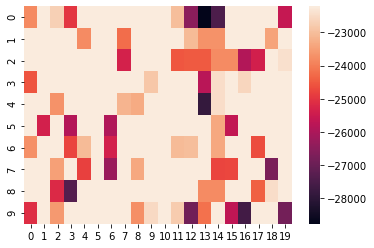

In [15]:
X=20
Y=10
pop_knap=create_knap_pop(dic,Y,X)
pop_tsp=create_tsp_pop(dic,Y,X)
fitness=fit_loop(dic,pop_tsp,pop_knap)
#iterations=1000
mr=.1
l=0
z=True
count=0
lastfit=np.amax(fitness)
while z:
    fitness=fit_loop(dic,pop_tsp,pop_knap)
    pop_knap,pop_tsp=cga.crossover(fitness,pop_knap,pop_tsp,Y,X,mr) 
    print("generation: ",l, " maximo: ", np.amax(fitness))
    l=l+1
    fitness=fit_loop(dic,pop_tsp,pop_knap)
    if lastfit>=np.amax(fitness):
        count=count+1
    else:
        count=0
    lastfit=np.amax(fitness)
    if count==100 :
        z=False

#print(maximos)

p1 = sns.heatmap(fitness)    
